In [50]:
##### make sure install happens in notebook environment

#import sys
#!{sys.executable} -m pip install geopandas

In [51]:
#import arcpy
import pandas as pd
import re
from io import StringIO

## Load MDA measurementes for comparison

In [56]:
import geopandas as gpd

path_to_shapefile = r"C:\Users\Usuario\OneDrive - UNIVERSIDAD DE HUELVA\Granada\TrabajoFM\Genil_ArcGIS_Pasca\MDA_test_data\Ptos_MDA_Cubillas_131517_data.shp"


df_DMA_this_script = gpd.read_file(path_to_shapefile)
df_DMA_this_script.drop(columns=["UTMX", "UTMY", "HUSO", "DATUM"], inplace=True)


In [57]:
df_DMA_this_script = df_cubillas_DMA_measur_13_17_15
df_DMA_this_script[["AP_corregi"]] = 100  # Placeholder value, replace with actual data if available

### Cleaning

In [ ]:
import numpy as np

# Step 1: Define columns to clean and convert to float
float_columns = ["RESULTADO", "AP_corregi"]

# Step 2: Report original row count
initial_len = len(df_DMA_this_script)

# Step 3: Clean and convert all float columns
for col in float_columns:
    if col not in df_DMA_this_script.columns:
        raise ValueError(f"Missing required column: {col}")
    
    df_DMA_this_script[col] = (
        df_DMA_this_script[col]
        .astype(str).str.replace(",", ".", regex=False)  # Convert comma to dot
        .str.strip()                                     # Remove whitespace
        .replace("", np.nan)                             # Replace empty string with NaN
        .apply(pd.to_numeric, errors="coerce")           # Convert to float, force NaNs on error
    )

# Step 4: Drop rows with NaNs
df_cleaned = df_DMA_this_script.dropna(subset=float_columns)
dropped_na = initial_len - len(df_cleaned)
if dropped_na > 0:
    print(f"⚠️ Dropped {dropped_na} rows due to non-numeric or missing values in: {', '.join(float_columns)}.")

# Step 5: Handle values marked as "below detection limit" using negative numbers
# In the input data, values originally written as "<X" (e.g., "<0.5") were converted to "-X" during preprocessing
# but these values do not represent true negatives — rather,
# they indicate concentrations below the detection limit ("non-detects").

# Environmental data practice recommends replacing these with half the detection limit for analysis:
# Example: original "<0.5" → stored as -0.5 → replaced with 0.25

# We apply this logic across all float columns, replacing negative values with half their absolute value.
for col in float_columns:
    if pd.api.types.is_numeric_dtype(df_cleaned[col]):
        neg_values = df_cleaned[col] < 0
        if neg_values.any():
            count_neg = neg_values.sum()
            # Replace each -X with abs(X) / 2
            df_cleaned.loc[neg_values, col] = df_cleaned.loc[neg_values, col].abs() / 2
            print(f"⚠️ Replaced {count_neg} 'below detection limit' values in column '{col}' with half the detection limit.")







⚠️ Dropped 212 rows due to non-numeric or missing values in: RESULTADO, AP_corregi.
⚠️ Replaced 410 'below detection limit' values in column 'RESULTADO' with half the detection limit.


C:\Users\Usuario\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


RESULTADO  AP_corregi  kg_per_day
0          0.04         100         4.0
1          0.02         100         2.0
2          0.10         100        10.0
3          0.28         100        28.0
4          0.77         100        77.0
...         ...         ...         ...
3767       8.00         100       800.0
3768       8.00         100       800.0
3769       8.80         100       880.0
3770      13.00         100      1300.0
3771      17.00         100      1700.0

[3560 rows x 3 columns]

## Load Cubillas water apportation info

#### Adapt

In [ ]:
# Step 6: )
df_cleaned["kg_per_day"] = df_cleaned["RESULTADO"] * df_cleaned["AP_corregi"]

# Optional: Replace original dataframe
# df_DMA_this_script = df_cleaned.copy()

# Preview result
df_cleaned[float_columns + ["kg_per_day"]]

In [ ]:
# Compute kg_per_day from water aportation and concentration
# RESULTADO is in mg/L, AP_corregi is in L/day (WHERE DID I GET THIS DATA FROM AGAIN?
df_cleaned["kg_por_dia"] = (
    df_cleaned["RESULTADO"] * df_cleaned["AP_corregi"]
)

# Optional: replace original df if desired
df_DMA_this_script = df_cleaned.copy()

# Preview
df_DMA_this_script[float_columns + ["kg_por_dia"]]

C:\Users\Usuario\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


RESULTADO  AP_corregi  kg_por_dia
0          0.04         100         4.0
1          0.02         100         2.0
2          0.10         100        10.0
3          0.28         100        28.0
4          0.77         100        77.0
...         ...         ...         ...
3767       8.00         100       800.0
3768       8.00         100       800.0
3769       8.80         100       880.0
3770      13.00         100      1300.0
3771      17.00         100      1700.0

[3560 rows x 3 columns]

In [65]:


def clean_data(df_cubillas_chem_measur):
    # Convert object columns to datetime if not already
    date_columns = ['F_MUESTREO', 'F_ALTA', 'F_BAJA', 'Fecha_Camb', 'Fecha__día_']
    for col in date_columns:
        if col in df_cubillas_chem_measur.columns:
            df_cubillas_chem_measur[col] = pd.to_datetime(df_cubillas_chem_measur[col], errors='coerce')

    # Clean and convert 'kg_por_dia' column to float
    df_cubillas_chem_measur["kg_por_dia"] = (
    df_cubillas_chem_measur["kg_por_dia"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .astype(float) )
    return df_cubillas_chem_measur



In [61]:
df_cubillas_chem_measur_clean = clean_data(df_cubillas_chem_measur.copy())
df_DMA_this_script_clean = clean_data(df_DMA_this_script.copy())
df_DMA_this_script_clean

Join_Count  TARGET_FID est_estaci   COD_UE  COD_PUNTO_ F_MUESTREO  \
0              1       13800      30303  30303-O  GV10090004 1994-07-01   
1              1       13801      30303  30303-O  GV10090004 1994-08-01   
2              1       13802      30303  30303-O  GV10090004 1994-09-01   
3              1       13803      30303  30303-O  GV10090004 1994-10-01   
4              1       13804      30303  30303-O  GV10090004 1994-11-01   
...          ...         ...        ...      ...         ...        ...   
3767           1       19580      30309  30309_2   GV30309_2 2022-01-26   
3768           1       19581      30309  30309_2   GV30309_2 2022-02-24   
3769           1       19582      30309  30309_2   GV30309_2 2022-03-22   
3770           1       19583      30309  30309_2   GV30309_2 2022-04-11   
3771           1       19584      30309  30309_2   GV30309_2 2022-05-12   

                     NOMBRE  RESULTADO    UNIDAD COD_UE_1  ... ElevMin  \
0                    AMONIO       0.04  mg NH4/l     None  ...   606.0   
1                    AMONIO       0.02  mg NH4/l     None  ...   606.0   
2                    AMONIO       0.10  mg NH4/l     None  ...   606.0   
3                    AMONIO       0.28  mg NH4/l     None  ...   606.0   
4                    AMONIO       0.77  mg NH4/l     None  ...   606.0   
...                     ...        ...       ...      ...  ...     ...   
3767  TEMPERATURA "IN SITU"       8.00        ºC     None  ...   606.0   
3768  TEMPERATURA "IN SITU"       8.00        ºC     None  ...   606.0   
3769  TEMPERATURA "IN SITU"       8.80        ºC     None  ...   606.0   
3770  TEMPERATURA "IN SITU"      13.00        ºC     None  ...   606.0   
3771  TEMPERATURA "IN SITU"      17.00        ºC     None  ...   606.0   

     ElevMax Bname Shape_Leng HydroID OutletID                geometry  \
0      869.0  None    40000.0  300015   100001  POINT (439472 4125473)   
1      869.0  None    40000.0  300015   100001  POINT (439472 4125473)   
2      869.0  None    40000.0  300015   100001  POINT (439472 4125473)   
3      869.0  None    40000.0  300015   100001  POINT (439472 4125473)   
4      869.0  None    40000.0  300015   100001  POINT (439472 4125473)   
...      ...   ...        ...     ...      ...                     ...   
3767   869.0  None    40000.0  300015   100001  POINT (441741 4125145)   
3768   869.0  None    40000.0  300015   100001  POINT (441741 4125145)   
3769   869.0  None    40000.0  300015   100001  POINT (441741 4125145)   
3770   869.0  None    40000.0  300015   100001  POINT (441741 4125145)   
3771   869.0  None    40000.0  300015   100001  POINT (441741 4125145)   

     AP_corregi kg_per_day  kg_por_dia  
0           100        4.0         4.0  
1           100        2.0         2.0  
2           100       10.0        10.0  
3           100       28.0        28.0  
4           100       77.0        77.0  
...         ...        ...         ...  
3767        100      800.0       800.0  
3768        100      800.0       800.0  
3769        100      880.0       880.0  
3770        100     1300.0      1300.0  
3771        100     1700.0      1700.0  

[3560 rows x 42 columns]

In [62]:
################################## change data source


df_cubillas_chem_measur_clean = df_DMA_this_script_clean.copy()

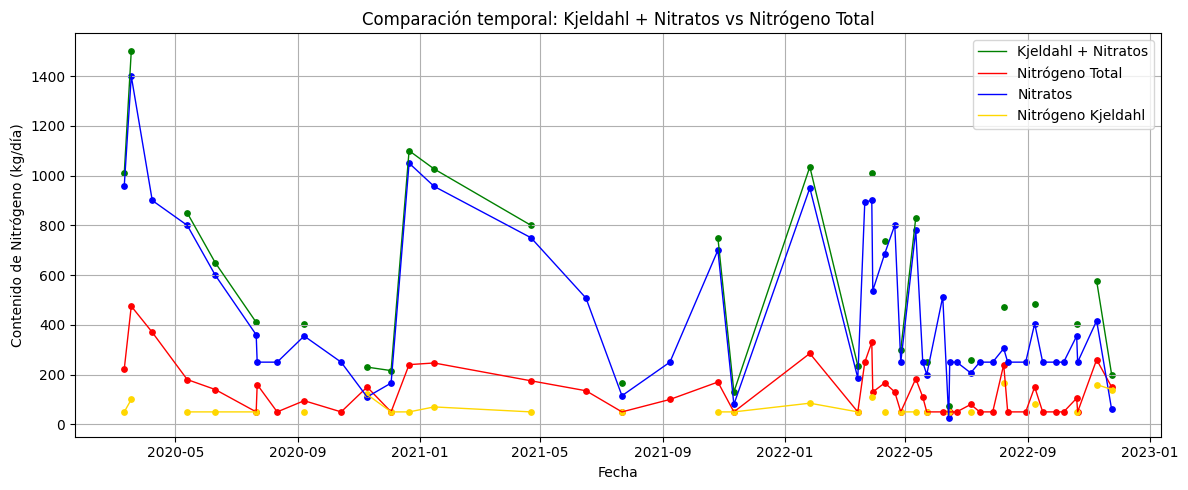

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure date is in datetime format
df = df_cubillas_chem_measur_clean.copy()
df["date"] = pd.to_datetime(df["F_MUESTREO"])

# Pivot table with mean aggregation
df_pivot = df.pivot_table(index="date", columns="NOMBRE", values="kg_por_dia", aggfunc='mean')

# Ensure numeric values
for col in ["NITROGENO KJELDAHL", "NITRATOS", "NITROGENO TOTAL"]:
    df_pivot[col] = pd.to_numeric(df_pivot[col], errors='coerce')

# Sum of KJELDAHL + NITRATOS
df_pivot["KJELDAHL_PLUS_NITRATOS"] = df_pivot["NITROGENO KJELDAHL"] + df_pivot["NITRATOS"]

# Filter to only dates where NITROGENO TOTAL is present
df_filtered = df_pivot[df_pivot["NITROGENO TOTAL"].notna()]

# Plotting
plt.figure(figsize=(12, 5))

# Thin lines
plt.plot(df_filtered.index, df_filtered["KJELDAHL_PLUS_NITRATOS"], color="green", linewidth=1, label="Kjeldahl + Nitratos")
plt.plot(df_filtered.index, df_filtered["NITROGENO TOTAL"], color="red", linewidth=1, label="Nitrógeno Total")
plt.plot(df_filtered.index, df_filtered["NITRATOS"], color="blue", linewidth=1, label="Nitratos")
plt.plot(df_filtered.index, df_filtered["NITROGENO KJELDAHL"], color="gold", linewidth=1, label="Nitrógeno Kjeldahl")

# Scatter points
plt.scatter(df_filtered.index, df_filtered["KJELDAHL_PLUS_NITRATOS"], color="green", s=15)
plt.scatter(df_filtered.index, df_filtered["NITROGENO TOTAL"], color="red", s=15)
plt.scatter(df_filtered.index, df_filtered["NITRATOS"], color="blue", s=15)
plt.scatter(df_filtered.index, df_filtered["NITROGENO KJELDAHL"], color="gold", s=15)

plt.xlabel("Fecha")
plt.ylabel("Contenido de Nitrógeno (kg/día)")
plt.title("Comparación temporal: Kjeldahl + Nitratos vs Nitrógeno Total")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The picture does not make sense because the units are not comparable! See Units in original table! Also check if this changes something for the later comparison with point source and swat output!

Nitratos are NH4 / L creo!

so I need to look at mol weight proportion of  the One N and 4 H and multiply the NH4 value with this proportion to get N/l values

NITROGENO TOTAL = mg N/l
NITROGENO KJELDAHL = mg N/l
NITRATOS = mg NO3/l
AMONIO = mg NH4/l  #### ???? am I using this if not why not?

FOSFORO TOTAL = mg P /l
FOSFATOS = mg PO4/l

## Sum all Subbasins' daily values

In [ ]:
plot_dayli_cubillas = df_sub_scaled.drop(columns=["SW", "SUB", "YEAR", "GIS", "MON", "AREA", "area_ha", "day_of_year", "total_days"])


plot_dayli_cubillas = plot_dayli_cubillas.groupby(["date"], as_index=False).sum(numeric_only=True)

# Add back year to daily table for filtering
plot_dayli_cubillas["YEAR"] = plot_dayli_cubillas["date"].dt.year
plot_dayli_cubillas

date      PRECIP  SNOMELT     PET      ET      PERC         SURQ  \
0     1991-01-01      0.0000      0.0  26.640   4.272   0.00000     0.001733   
1     1991-01-02      0.0000      0.0  56.610   8.560   0.00000     0.001733   
2     1991-01-03      0.0000      0.0  40.580   5.908   0.00000     0.001733   
3     1991-01-04      0.0000      0.0  34.160   4.851   0.00000     0.001733   
4     1991-01-05      0.0000      0.0  33.910   4.490   0.00000     0.001733   
...          ...         ...      ...     ...     ...       ...          ...   
12110 2024-02-27   1323.6009      0.0  19.816  13.101  18.53897  2489.930202   
12111 2024-02-28      0.0000      0.0  52.820  34.670   0.00000  1892.362665   
12112 2024-02-29      0.0000      0.0  53.170  27.660   0.00000  1484.410976   
12113 2024-03-01      0.0000      0.0  65.430  31.160   0.00000  1190.918156   
12114 2024-03-02  53042.0918      0.0  15.782  12.277   0.00000  1482.230299   

       GW_Q      WYLD          SYLD        ORGN       ORGP     NSURQ  \
0       0.0  0.000004  3.636400e-11    0.000002   0.000002  0.000002   
1       0.0  0.000004  3.636400e-11    0.000002   0.000002  0.000002   
2       0.0  0.000004  3.636400e-11    0.000002   0.000002  0.000002   
3       0.0  0.000004  3.636400e-11    0.000002   0.000002  0.000002   
4       0.0  0.000004  3.636400e-11    0.000002   0.000002  0.000002   
...     ...       ...           ...         ...        ...       ...   
12110   0.0  9.908480  2.886766e-01  267.927908  36.518348  0.745492   
12111   0.0  7.402960  4.354796e-02  176.281439  24.363403  0.621715   
12112   0.0  5.736340  1.912567e-02  122.045060  17.072559  0.520691   
12113   0.0  4.558410  1.048889e-02   88.454659  12.489646  0.439371   
12114   0.0  4.727590  8.179223e-02  127.437834  18.444416  1.554407   

               SOLP          SEDP  P_inorg_total  YEAR  
0      4.430000e-09  8.864000e-09   1.329400e-08  1991  
1      4.430000e-09  8.864000e-09   1.329400e-08  1991  
2      4.430000e-09  8.864000e-09   1.329400e-08  1991  
3      4.430000e-09  8.864000e-09   1.329400e-08  1991  
4      4.430000e-09  8.864000e-09   1.329400e-08  1991  
...             ...           ...            ...   ...  
12110  2.335151e-03  1.430816e-01   1.454168e-01  2024  
12111  1.801054e-03  8.213940e-02   8.394045e-02  2024  
12112  1.428310e-03  4.922120e-02   5.064951e-02  2024  
12113  1.154224e-03  3.096631e-02   3.212053e-02  2024  
12114  1.410275e-03  3.081301e-02   3.222329e-02  2024  

[12115 rows x 17 columns]

## Visualize SWAT vs. measured

In [ ]:
print(diversion_series_2["uncorrected - corrected"][diversion_series_2["uncorrected - corrected"] <= 0])

0       0.0
3       0.0
4       0.0
5       0.0
7       0.0
       ... 
9193    0.0
9195    0.0
9196    0.0
9197    0.0
9199    0.0
Name: uncorrected - corrected, Length: 5904, dtype: float64


[2000] Point source daily mean for 'NITRATOS': 0.00
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITRATOS\NITRATOS_2000.png


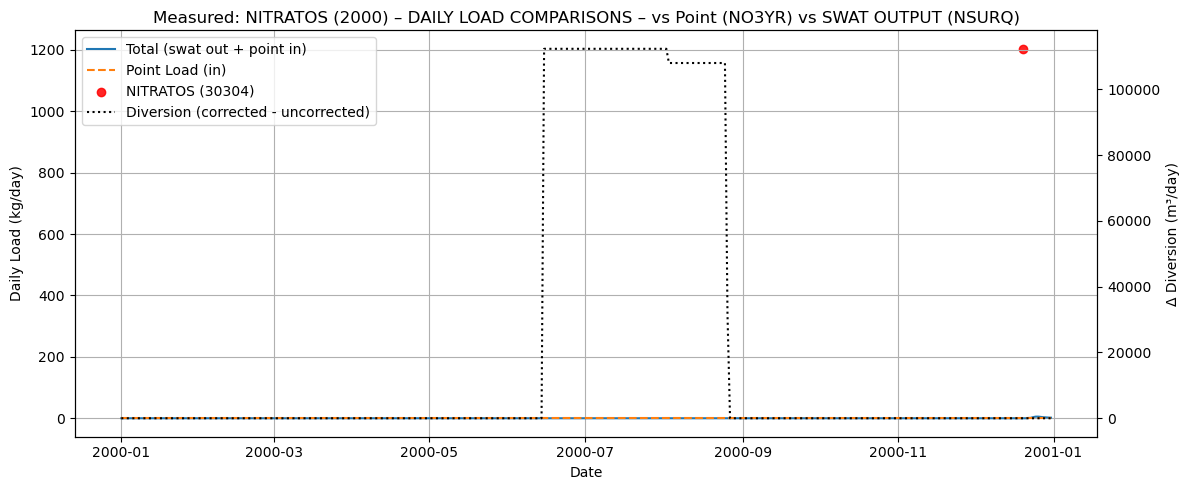

[2001] Point source daily mean for 'NITRATOS': 0.00
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITRATOS\NITRATOS_2001.png


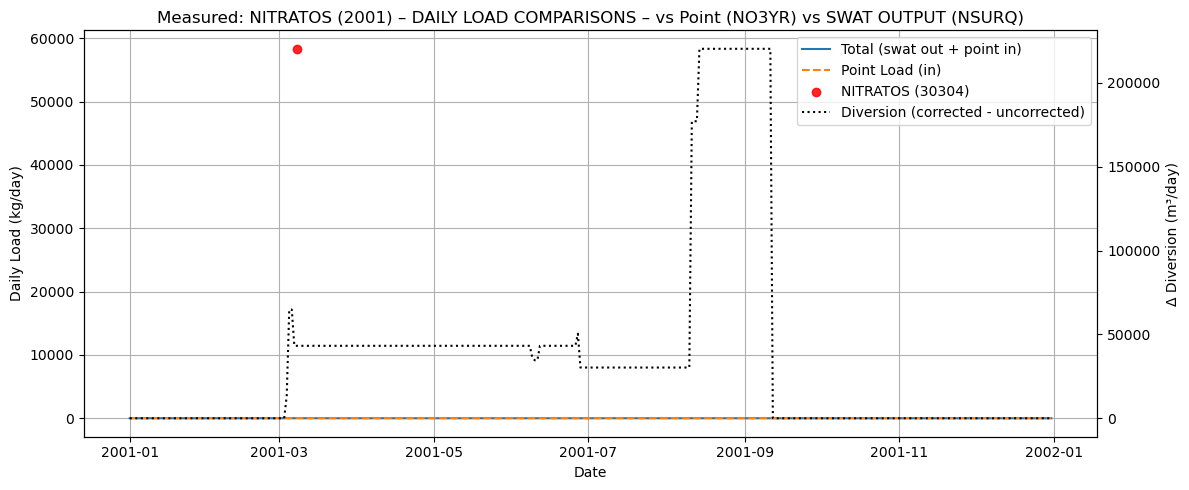

[2008] Point source daily mean for 'NITRATOS': 0.00
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITRATOS\NITRATOS_2008.png


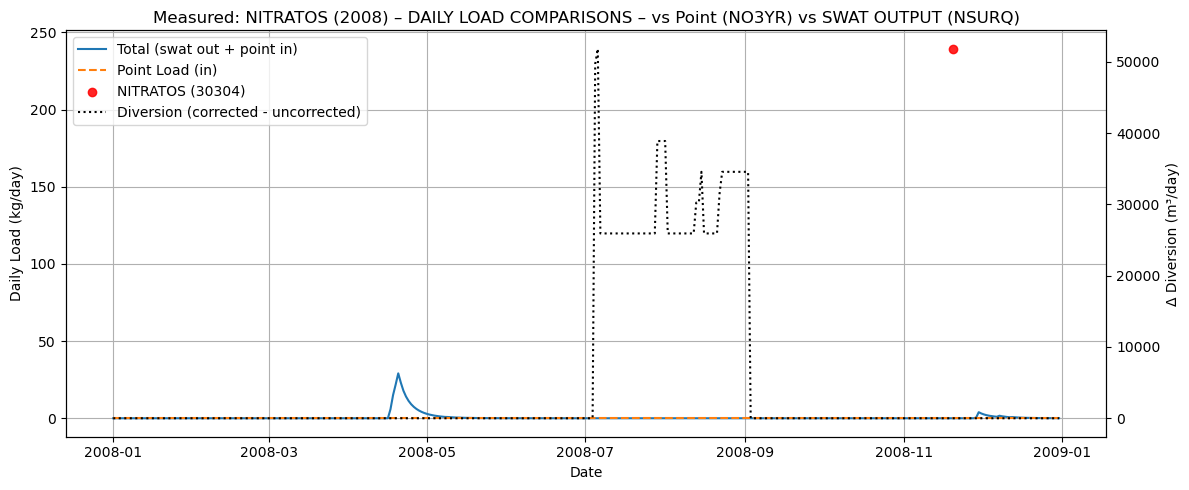

[2009] Point source daily mean for 'NITRATOS': 0.00
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITRATOS\NITRATOS_2009.png


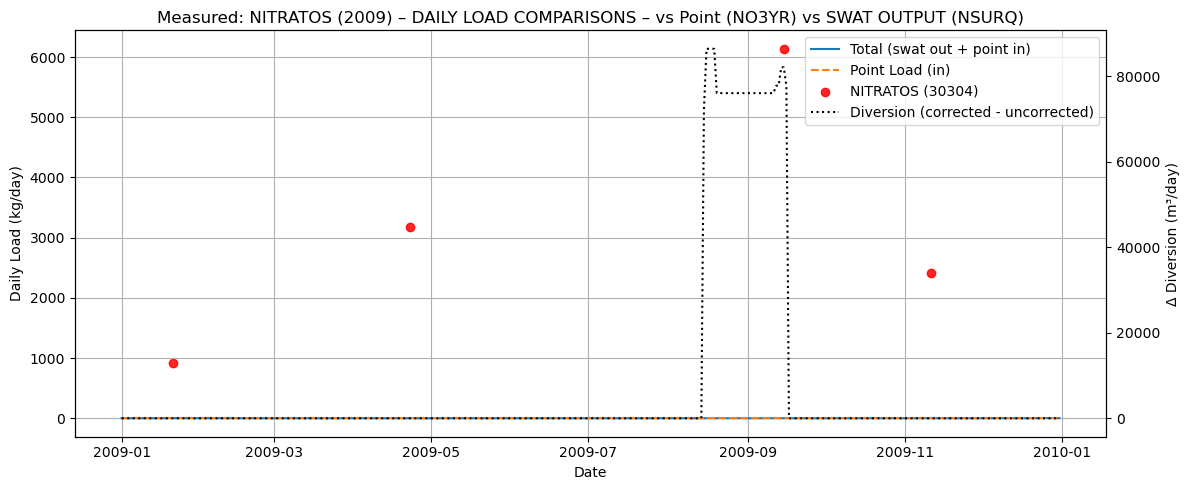

[2014] Point source daily mean for 'NITRATOS': 0.00
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITRATOS\NITRATOS_2014.png


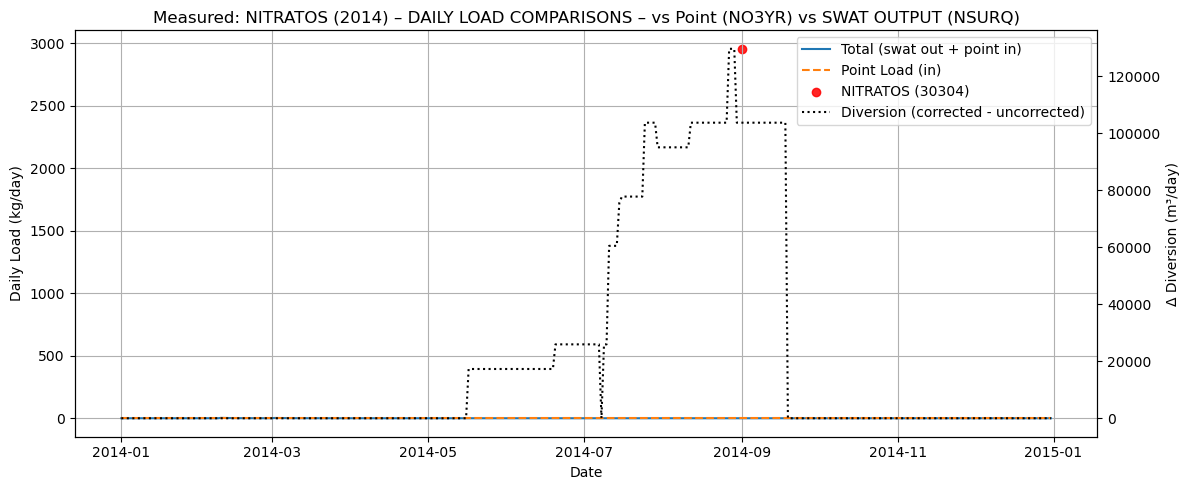

[2015] Point source daily mean for 'NITRATOS': 0.00
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITRATOS\NITRATOS_2015.png


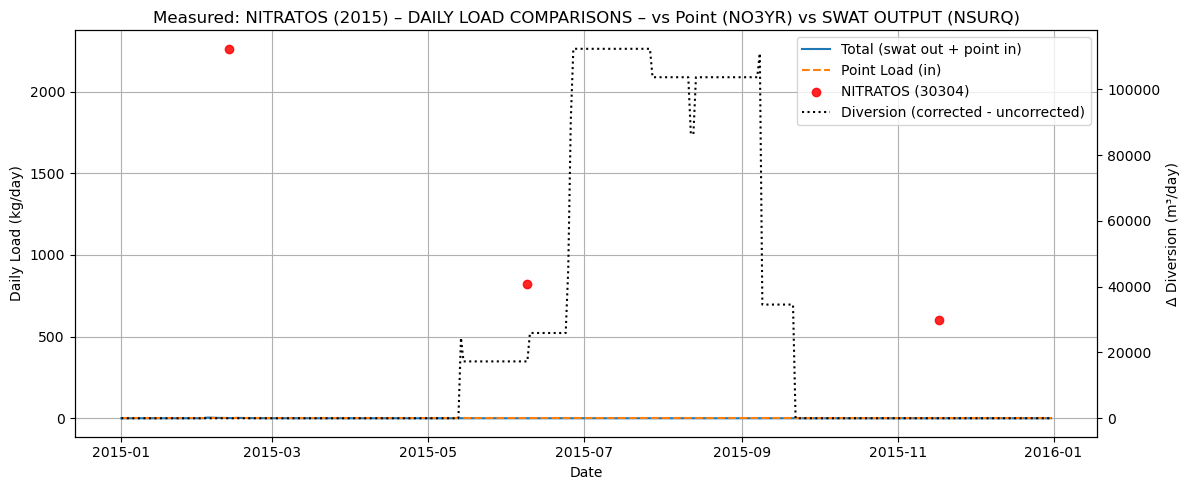

[2016] Point source daily mean for 'NITRATOS': 0.00
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITRATOS\NITRATOS_2016.png


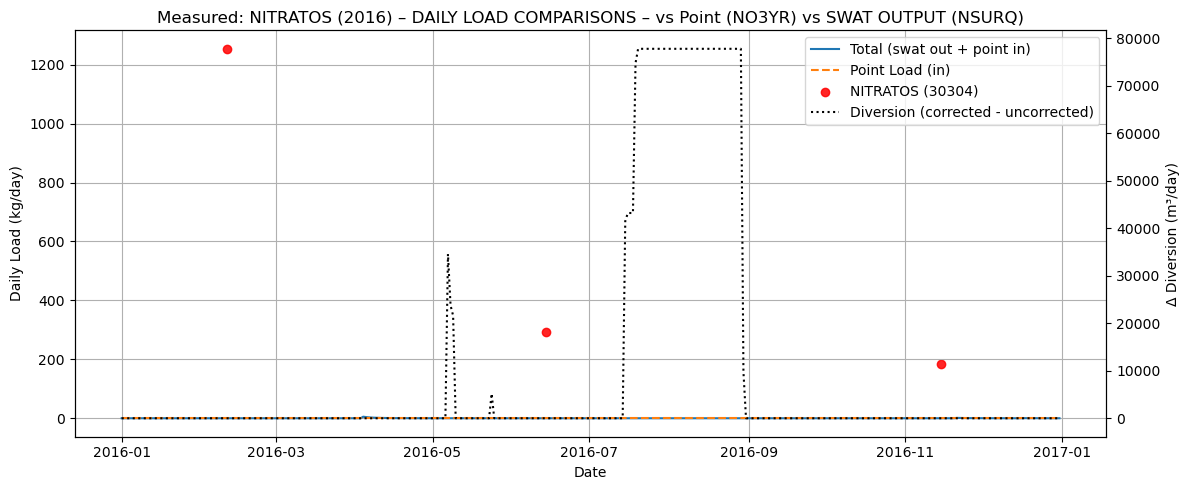

[2017] Point source daily mean for 'NITRATOS': 0.00
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITRATOS\NITRATOS_2017.png


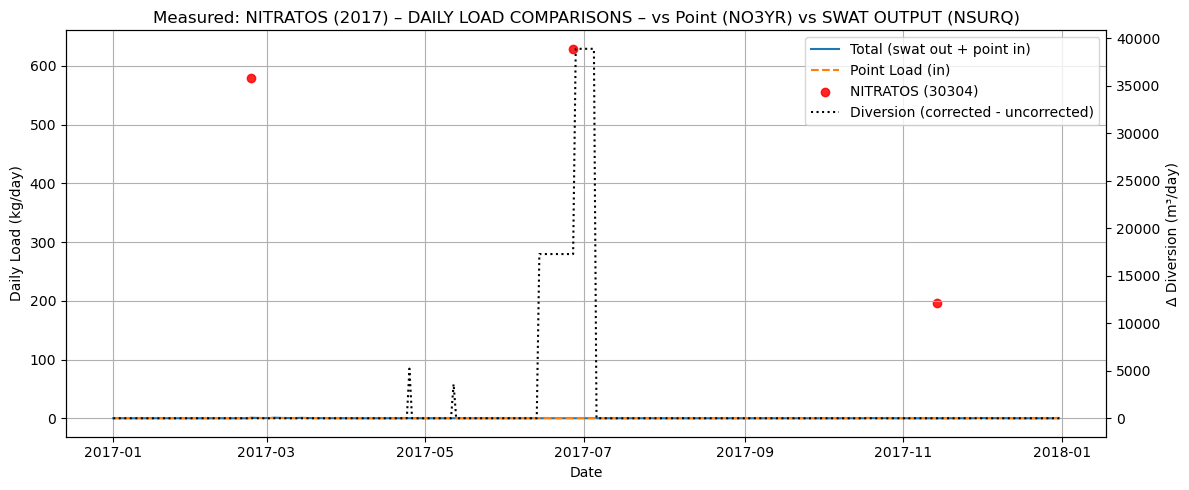

[2018] Point source daily mean for 'NITRATOS': 0.00
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITRATOS\NITRATOS_2018.png


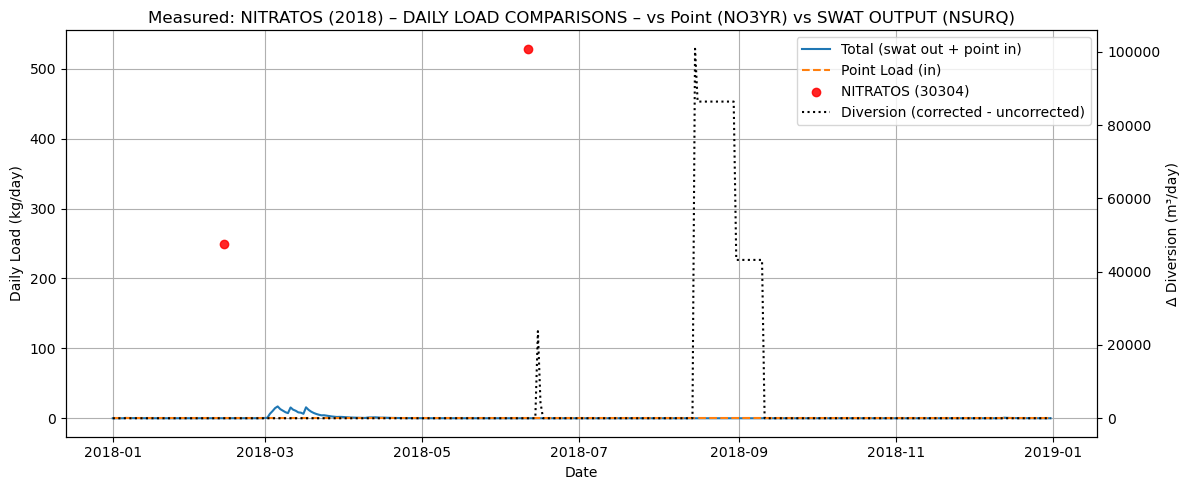

[2019] Point source daily mean for 'NITRATOS': 0.00
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITRATOS\NITRATOS_2019.png


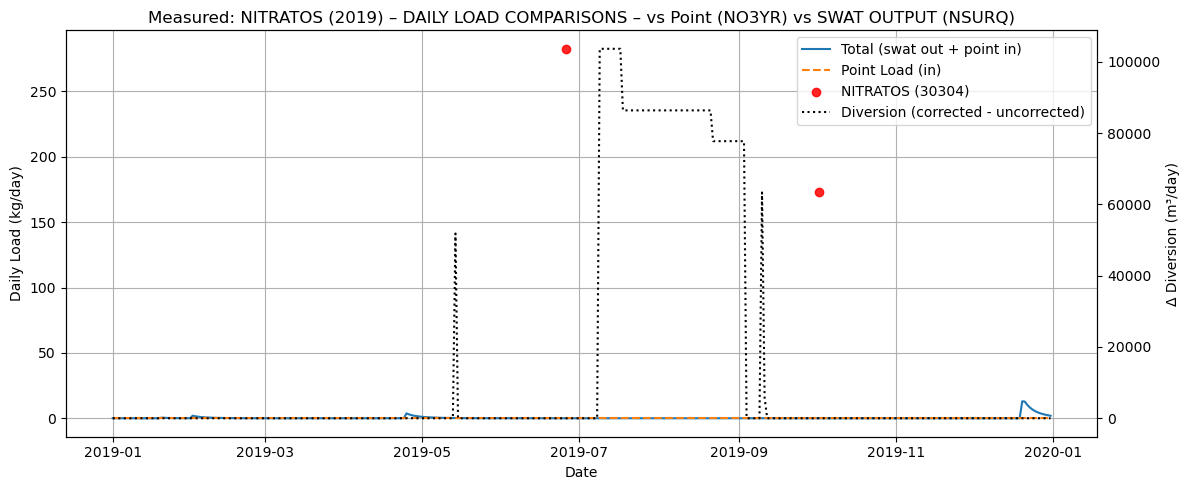

[2020] Point source daily mean for 'NITRATOS': 0.00
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITRATOS\NITRATOS_2020.png


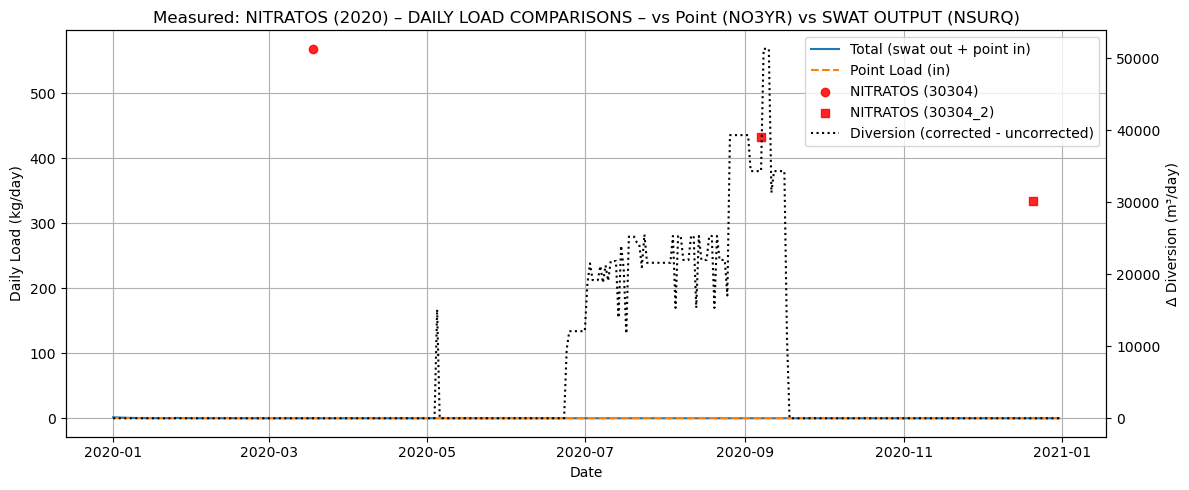

[2021] Point source daily mean for 'NITRATOS': 0.00
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITRATOS\NITRATOS_2021.png


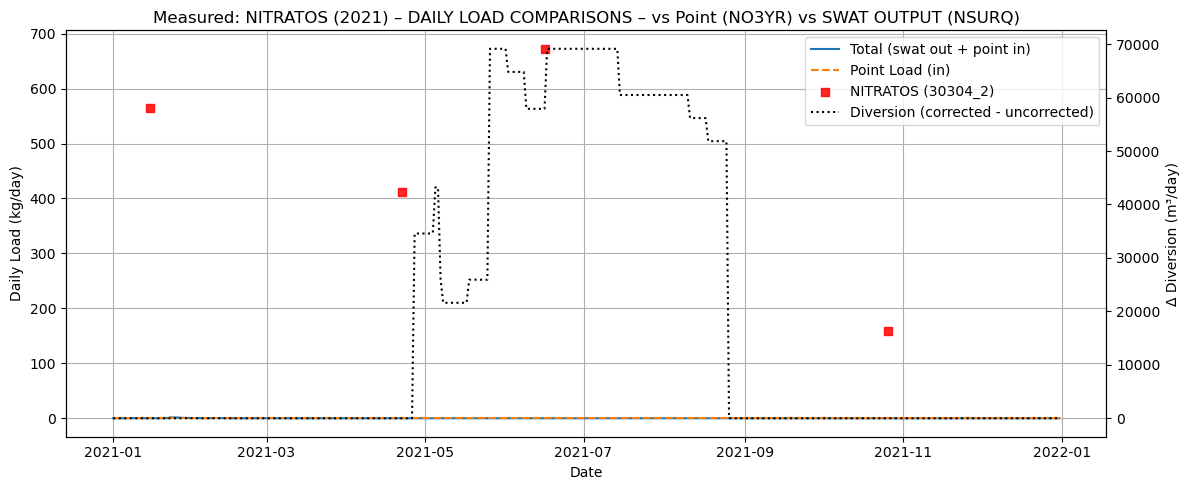

[2022] Point source daily mean for 'NITRATOS': 0.00
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITRATOS\NITRATOS_2022.png


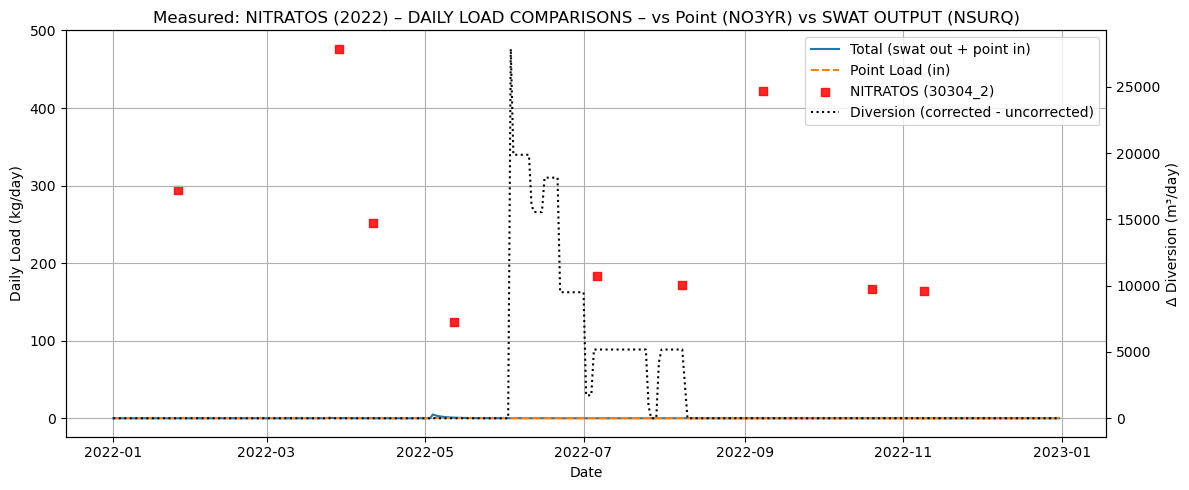

[2000] Point source daily mean for 'FOSFATOS': 11.74
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFATOS\FOSFATOS_2000.png


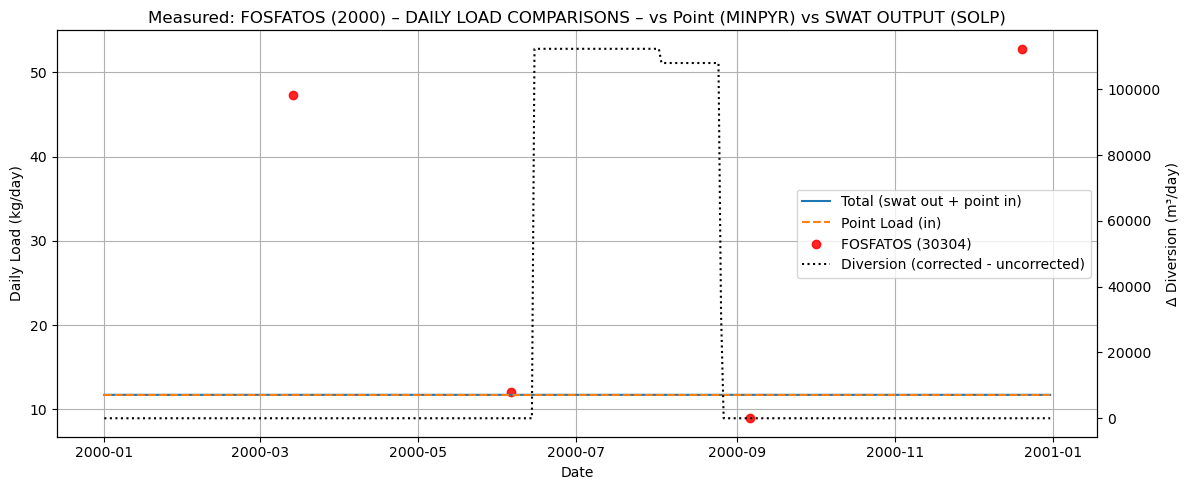

[2001] Point source daily mean for 'FOSFATOS': 11.77
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFATOS\FOSFATOS_2001.png


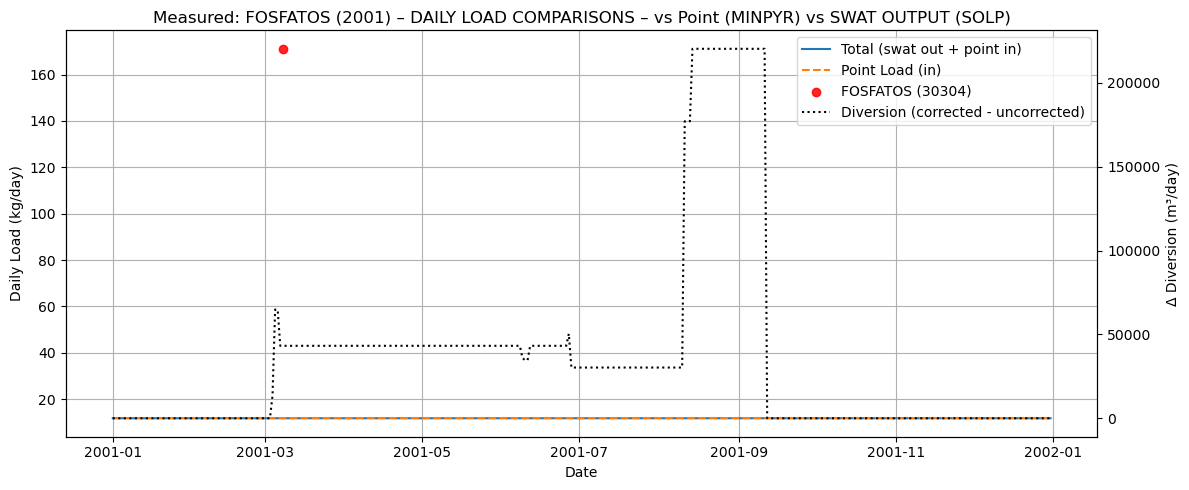

[2008] Point source daily mean for 'FOSFATOS': 11.78
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFATOS\FOSFATOS_2008.png


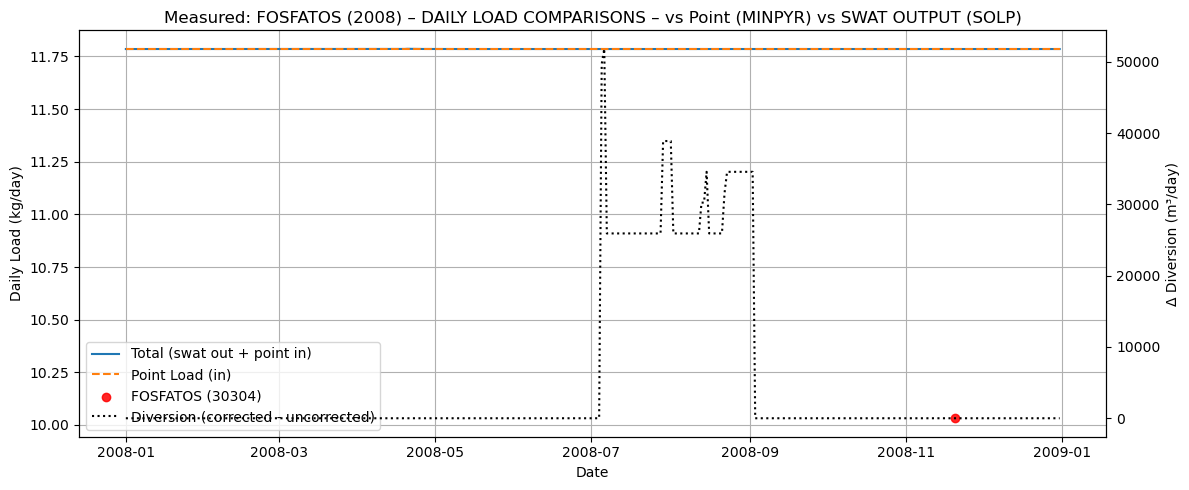

[2009] Point source daily mean for 'FOSFATOS': 11.79
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFATOS\FOSFATOS_2009.png


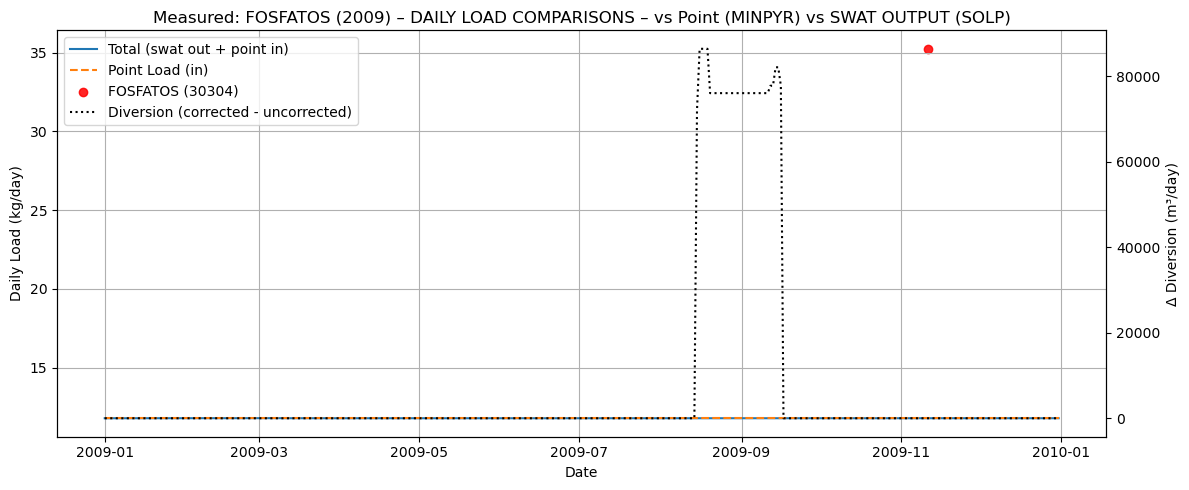

[2015] Point source daily mean for 'FOSFATOS': 11.71
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFATOS\FOSFATOS_2015.png


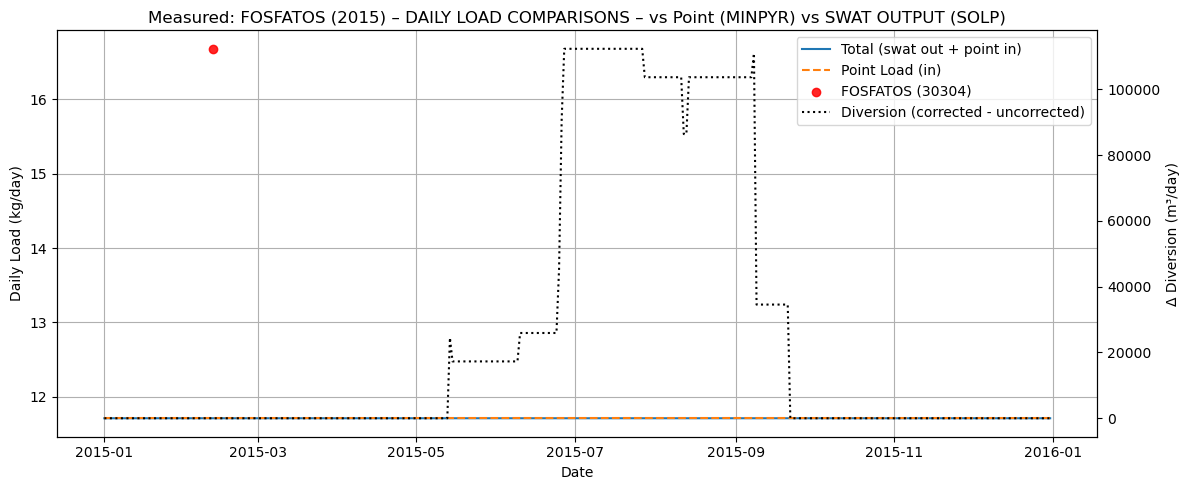

[2016] Point source daily mean for 'FOSFATOS': 11.69
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFATOS\FOSFATOS_2016.png


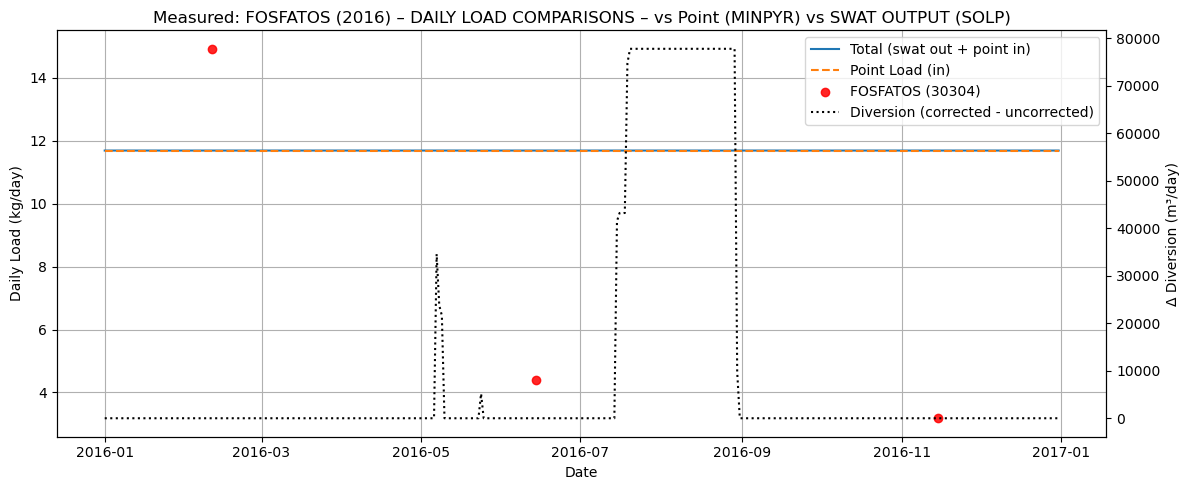

[2017] Point source daily mean for 'FOSFATOS': 11.67
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFATOS\FOSFATOS_2017.png


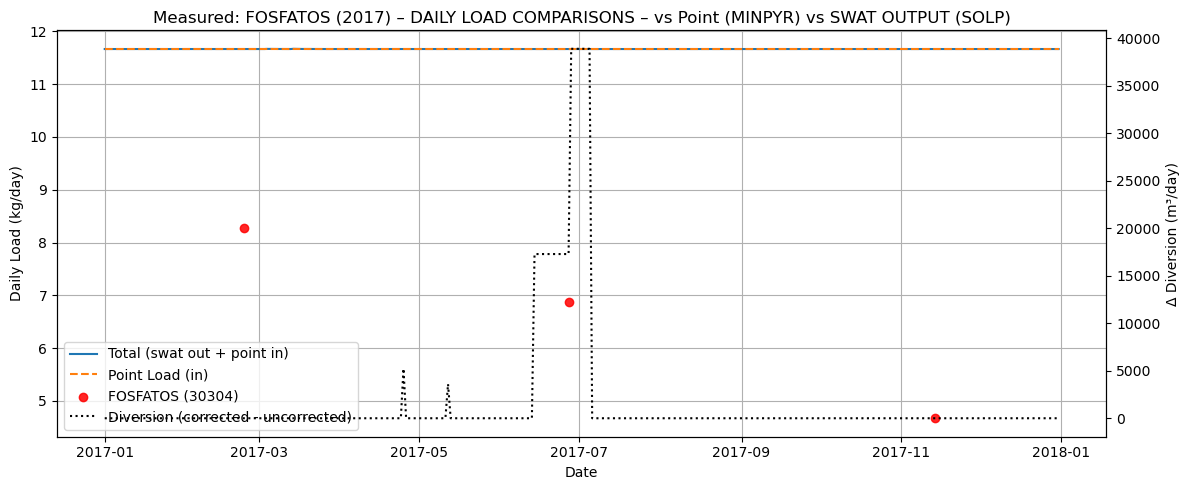

[2018] Point source daily mean for 'FOSFATOS': 11.64
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFATOS\FOSFATOS_2018.png


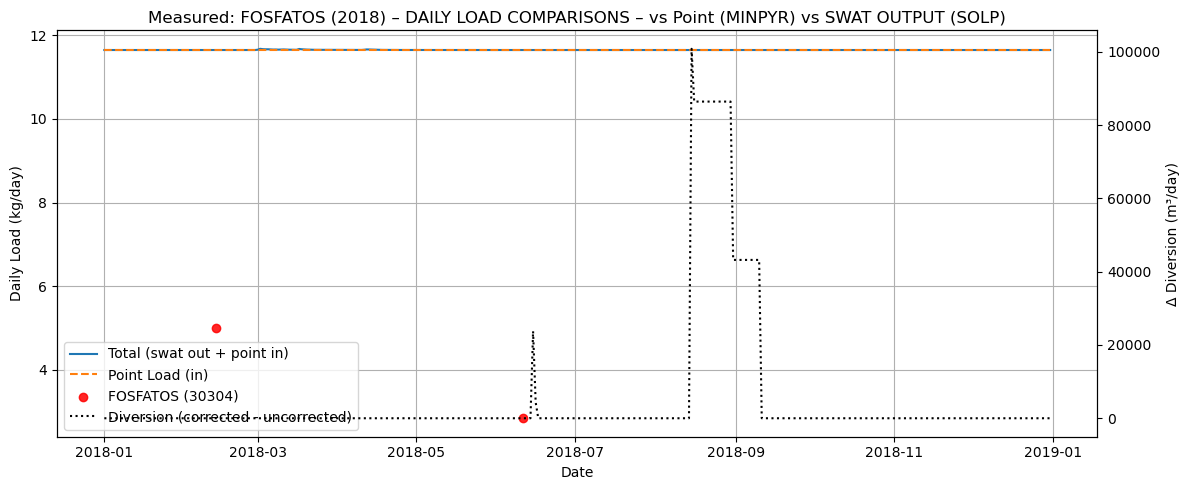

[2020] Point source daily mean for 'FOSFATOS': 11.60
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFATOS\FOSFATOS_2020.png


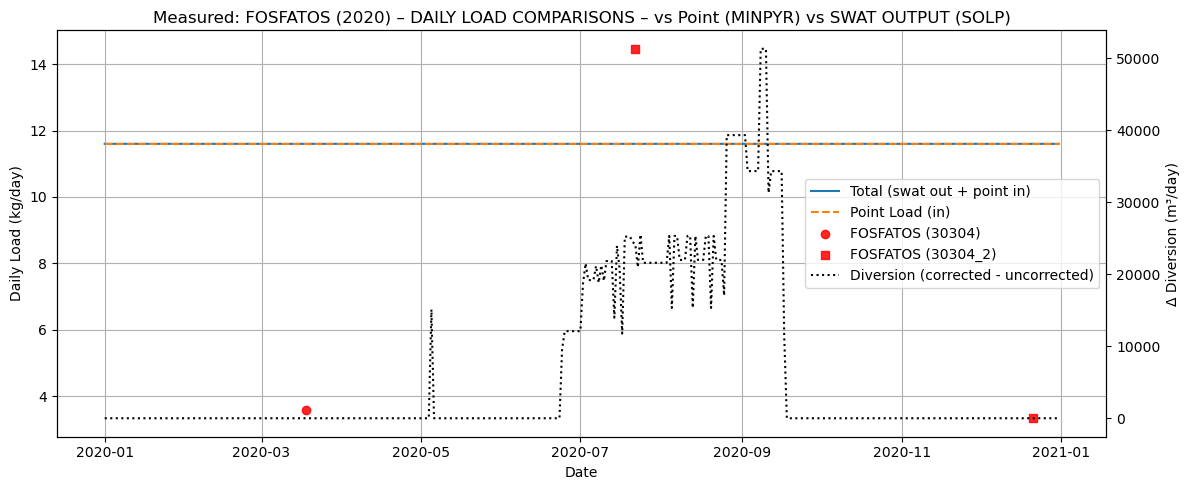

[2021] Point source daily mean for 'FOSFATOS': 11.58
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFATOS\FOSFATOS_2021.png


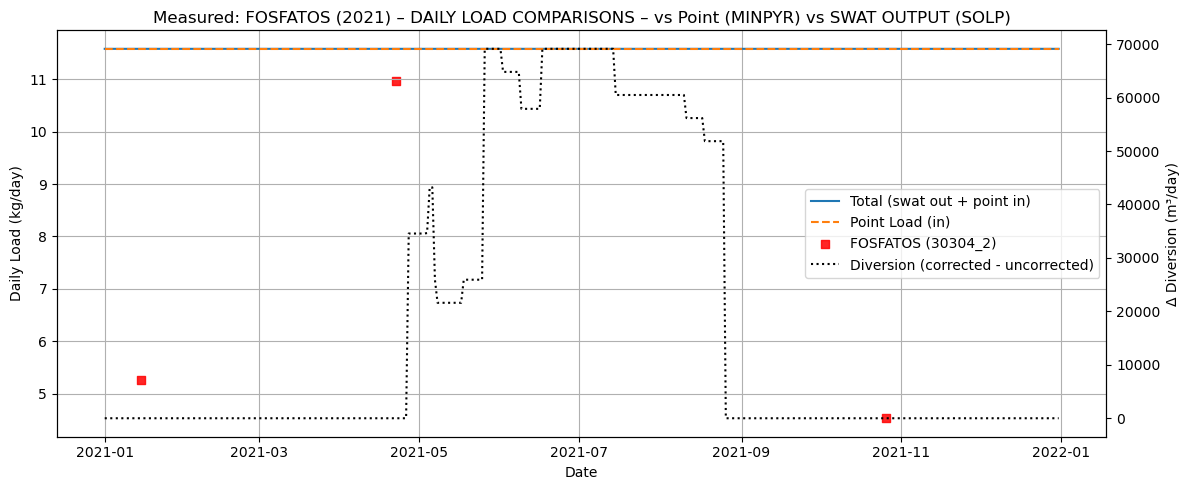

[2022] Point source daily mean for 'FOSFATOS': 11.57
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFATOS\FOSFATOS_2022.png


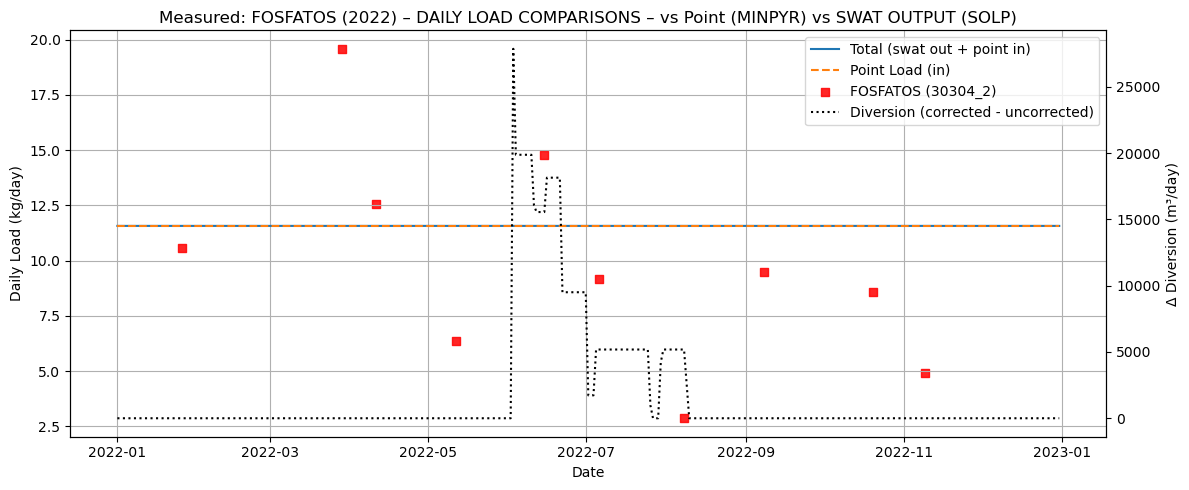

[2001] Point source daily mean for 'NITROGENO KJELDAHL': 35.30
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITROGENO_KJELDAHL\NITROGENO_KJELDAHL_2001.png


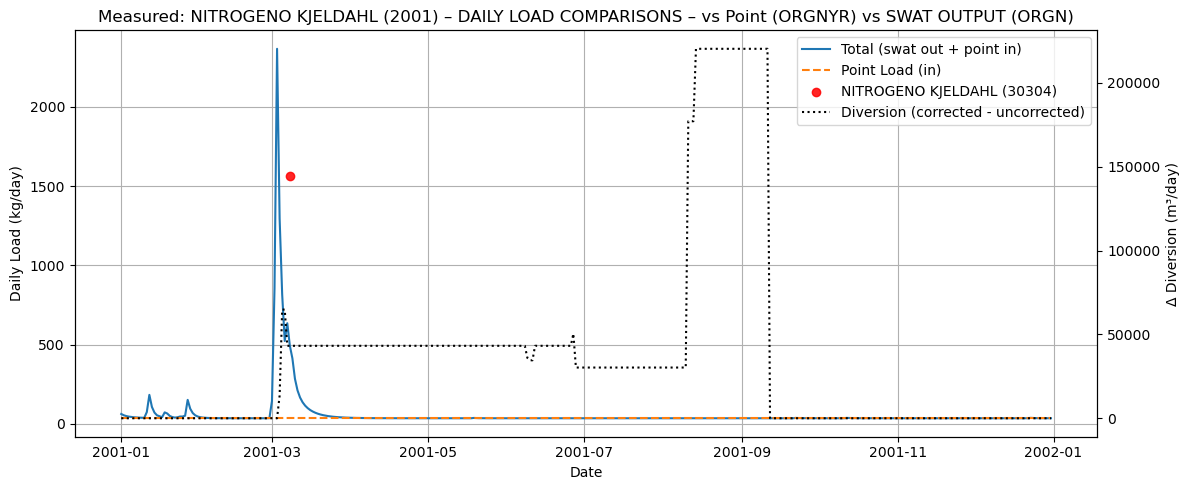

[2022] Point source daily mean for 'NITROGENO KJELDAHL': 34.71
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITROGENO_KJELDAHL\NITROGENO_KJELDAHL_2022.png


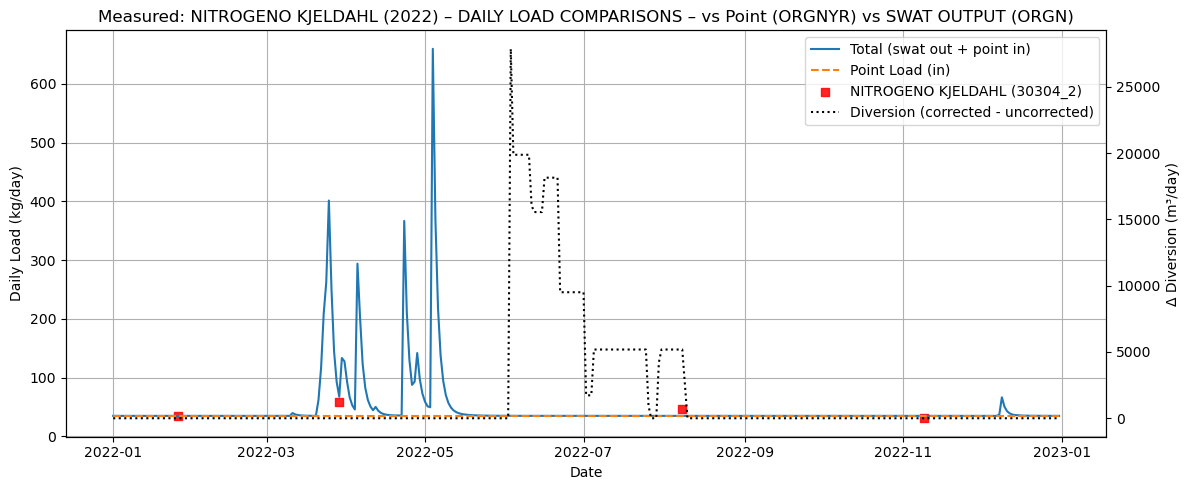

[2020] Point source daily mean for 'NITROGENO TOTAL': 34.80
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITROGENO_TOTAL\NITROGENO_TOTAL_2020.png


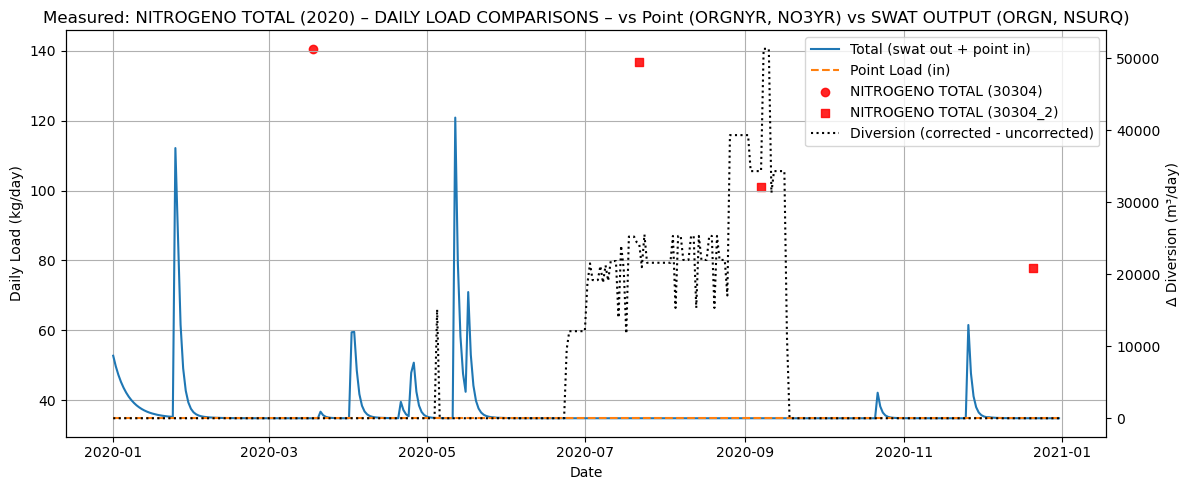

[2021] Point source daily mean for 'NITROGENO TOTAL': 34.75
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITROGENO_TOTAL\NITROGENO_TOTAL_2021.png


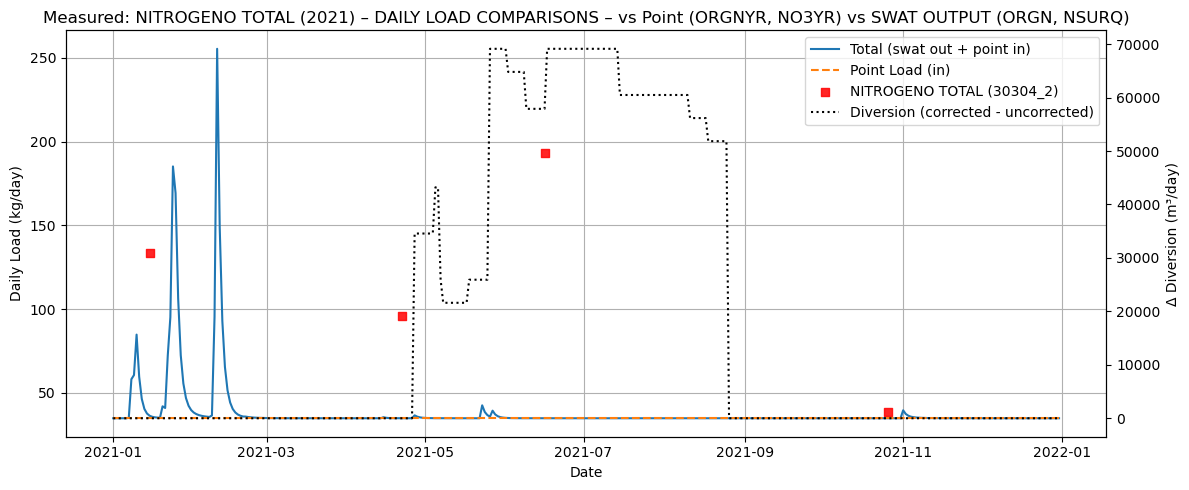

[2022] Point source daily mean for 'NITROGENO TOTAL': 34.71
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\NITROGENO_TOTAL\NITROGENO_TOTAL_2022.png


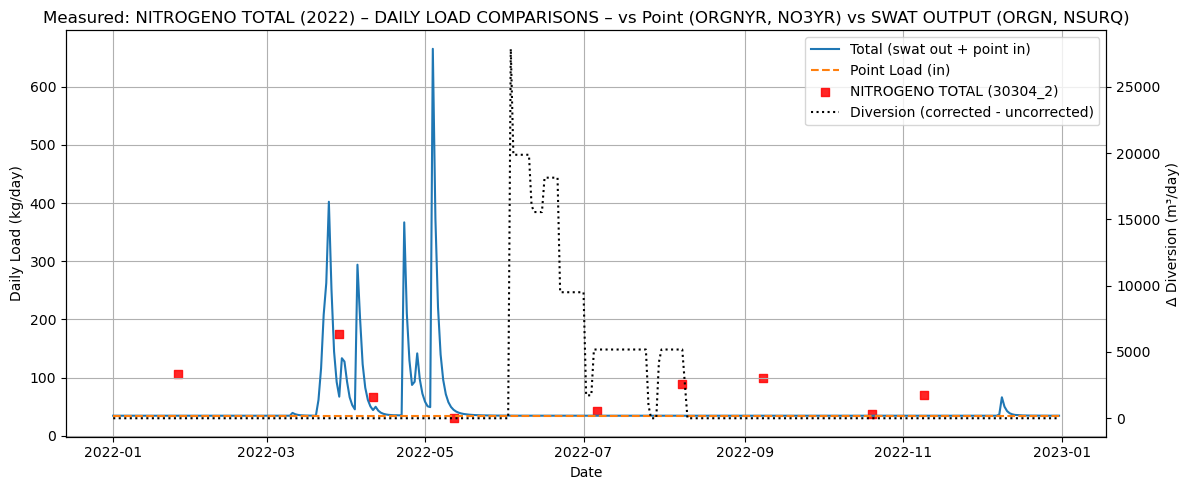

[2000] Point source daily mean for 'FOSFORO TOTAL': 18.78
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFORO_TOTAL\FOSFORO_TOTAL_2000.png


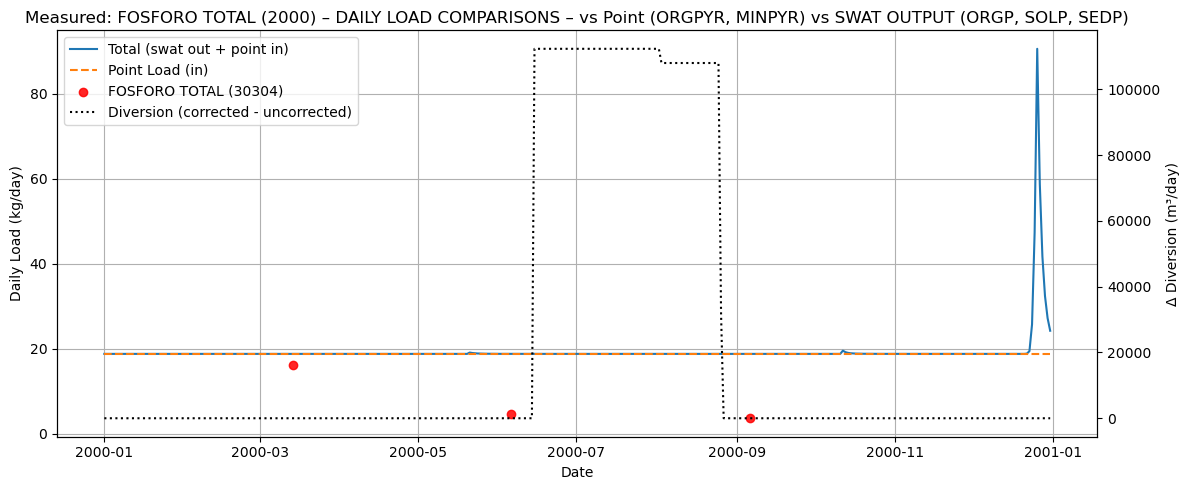

[2001] Point source daily mean for 'FOSFORO TOTAL': 18.82
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFORO_TOTAL\FOSFORO_TOTAL_2001.png


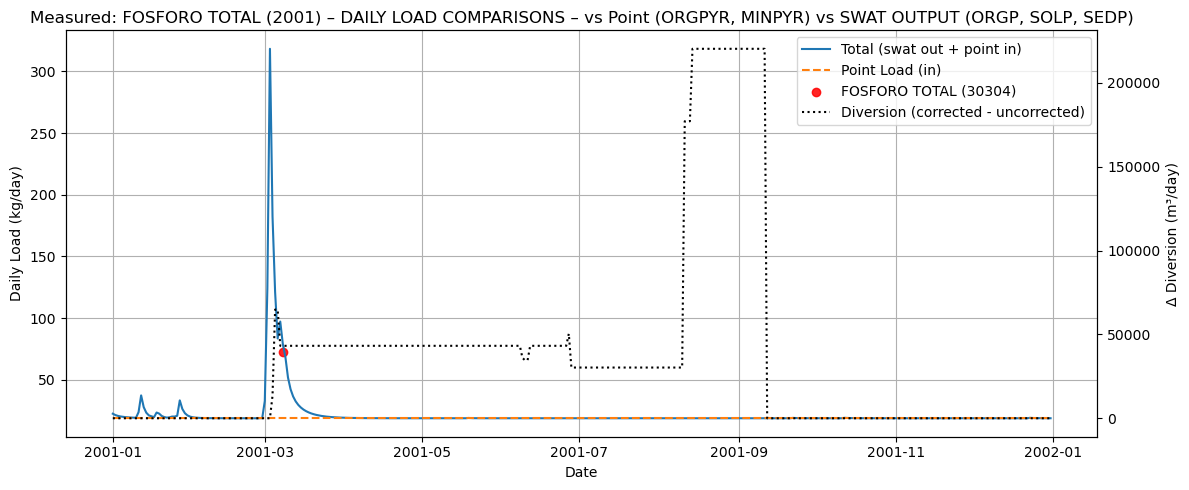

[2008] Point source daily mean for 'FOSFORO TOTAL': 18.86
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFORO_TOTAL\FOSFORO_TOTAL_2008.png


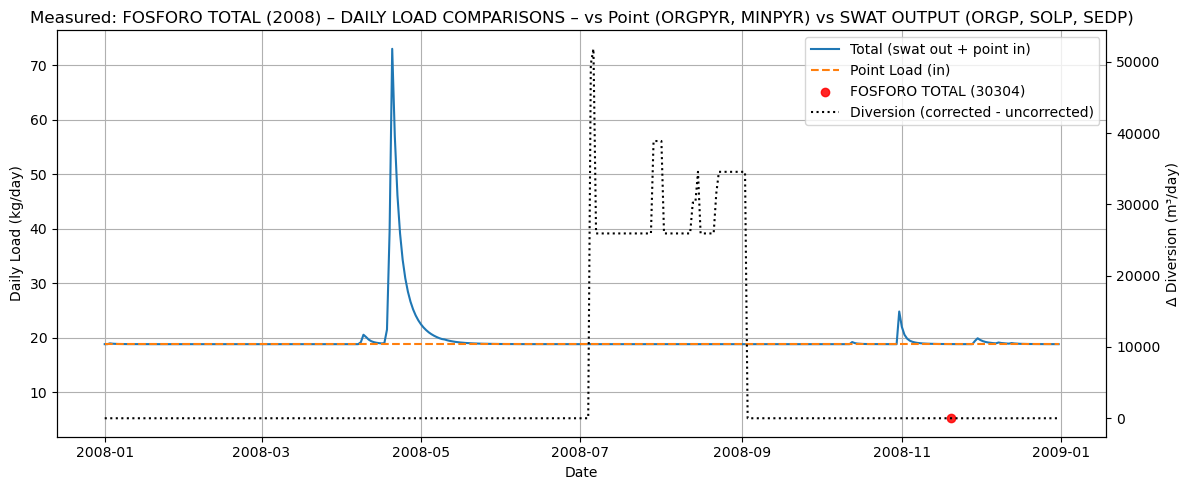

[2009] Point source daily mean for 'FOSFORO TOTAL': 18.86
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFORO_TOTAL\FOSFORO_TOTAL_2009.png


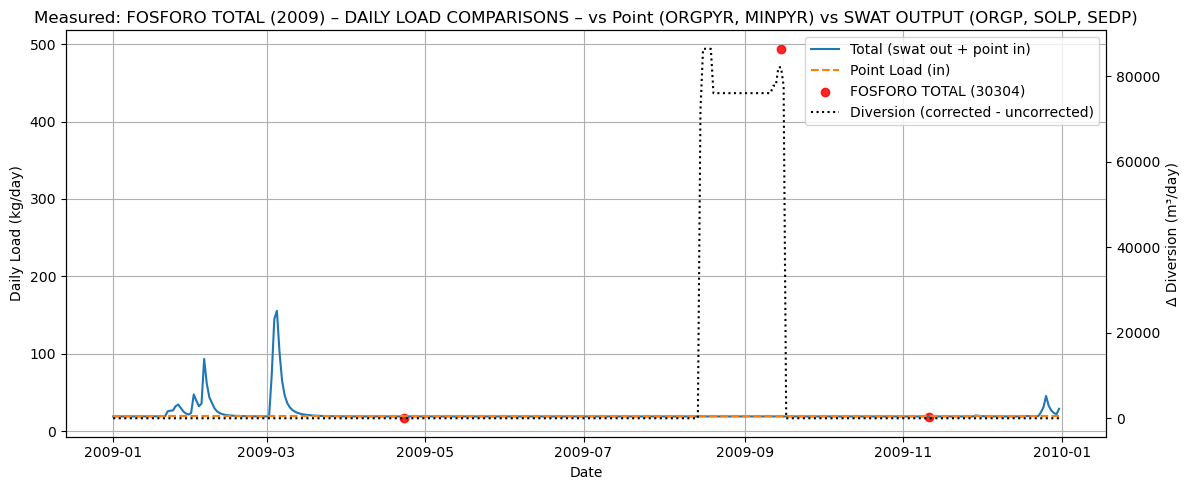

[2014] Point source daily mean for 'FOSFORO TOTAL': 18.77
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFORO_TOTAL\FOSFORO_TOTAL_2014.png


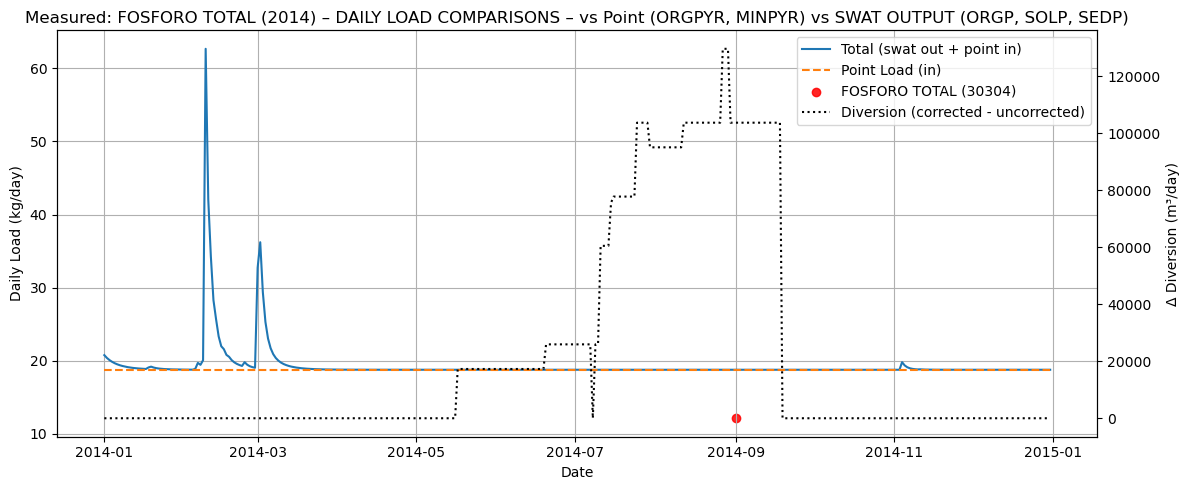

[2015] Point source daily mean for 'FOSFORO TOTAL': 18.74
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFORO_TOTAL\FOSFORO_TOTAL_2015.png


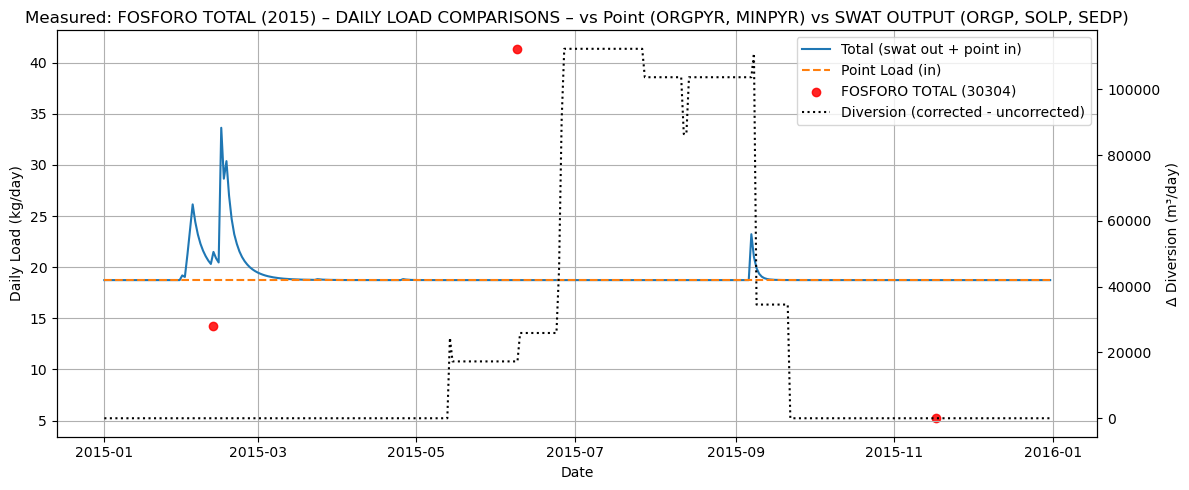

[2016] Point source daily mean for 'FOSFORO TOTAL': 18.70
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFORO_TOTAL\FOSFORO_TOTAL_2016.png


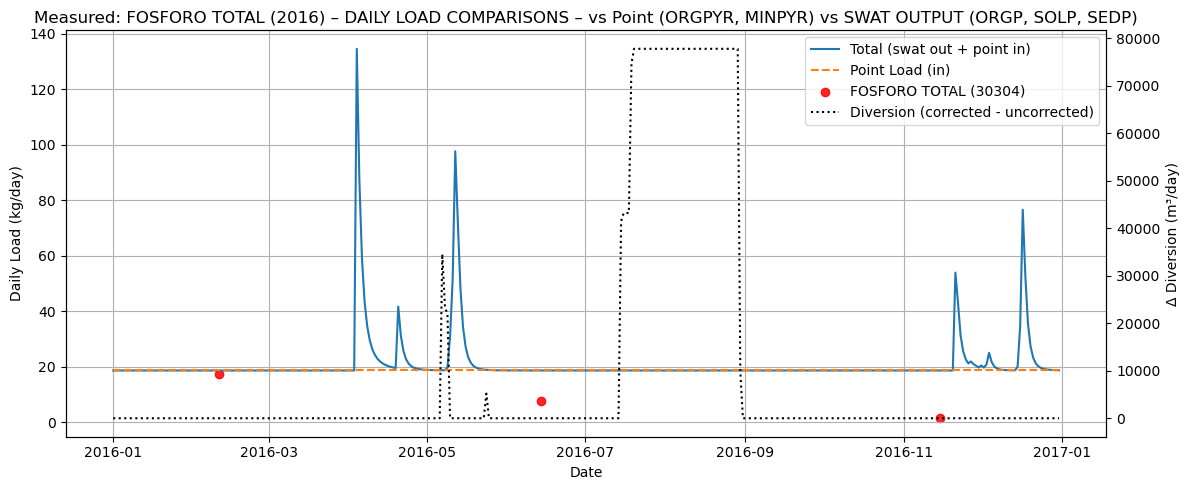

[2017] Point source daily mean for 'FOSFORO TOTAL': 18.67
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFORO_TOTAL\FOSFORO_TOTAL_2017.png


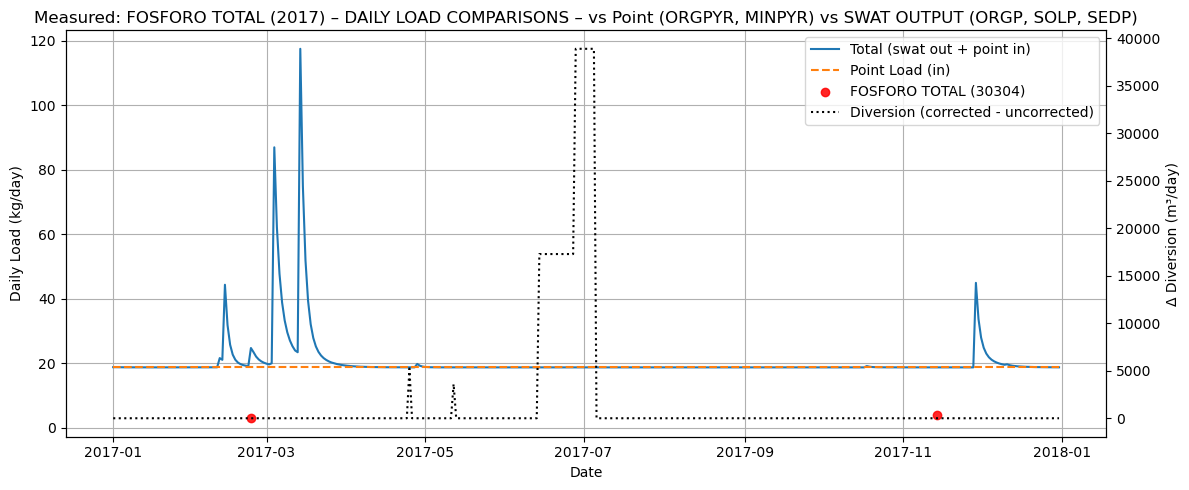

[2018] Point source daily mean for 'FOSFORO TOTAL': 18.63
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFORO_TOTAL\FOSFORO_TOTAL_2018.png


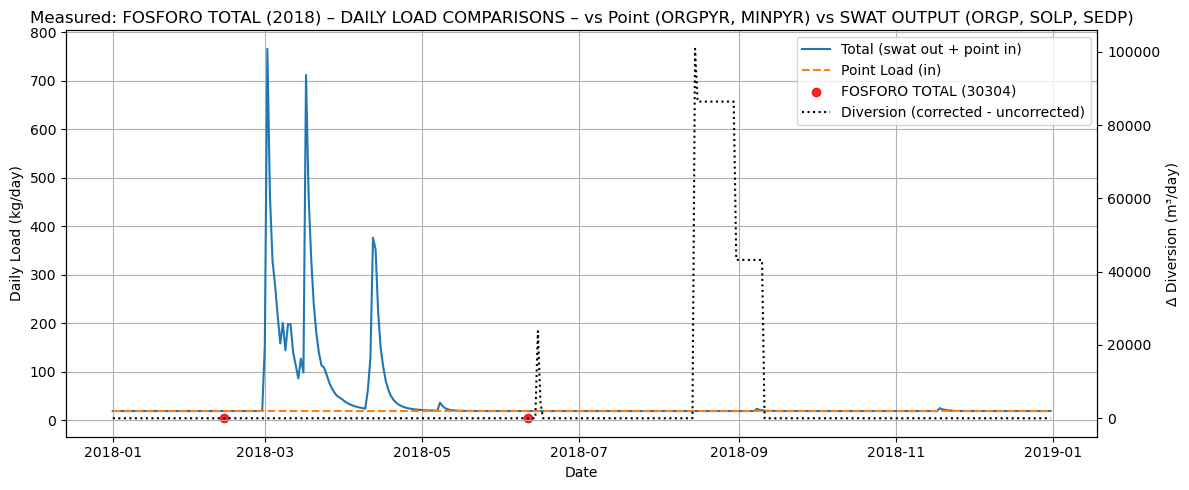

[2020] Point source daily mean for 'FOSFORO TOTAL': 18.56
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFORO_TOTAL\FOSFORO_TOTAL_2020.png


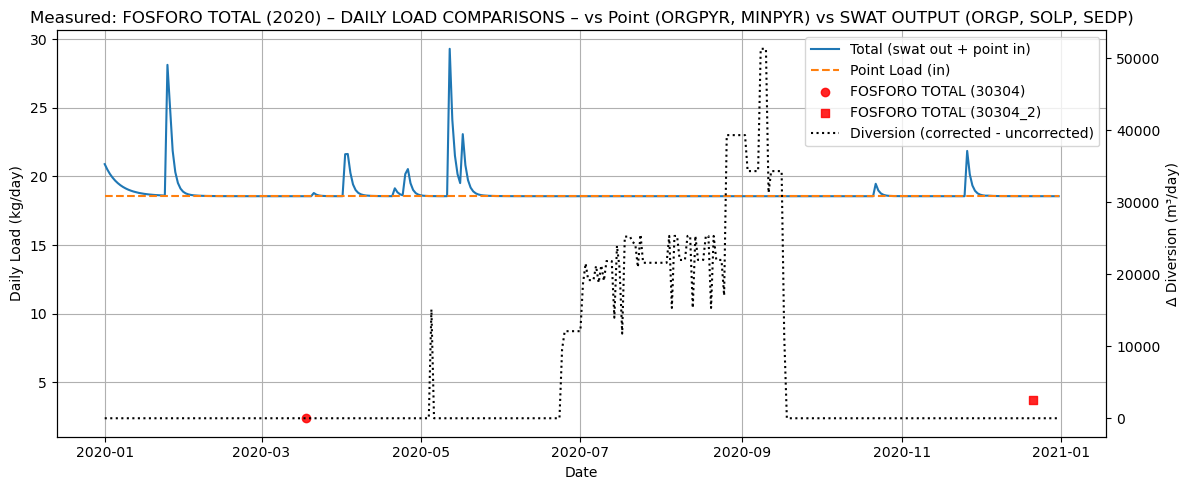

[2021] Point source daily mean for 'FOSFORO TOTAL': 18.54
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFORO_TOTAL\FOSFORO_TOTAL_2021.png


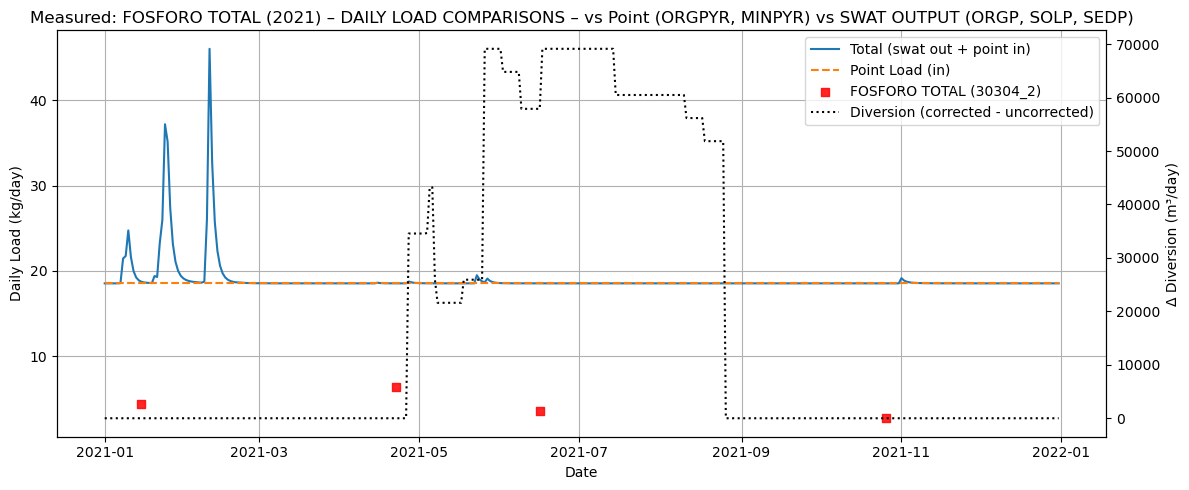

[2022] Point source daily mean for 'FOSFORO TOTAL': 18.51
✅ Saved: plots_read_sub/comparing_dma_swat_point_diversion\FOSFORO_TOTAL\FOSFORO_TOTAL_2022.png


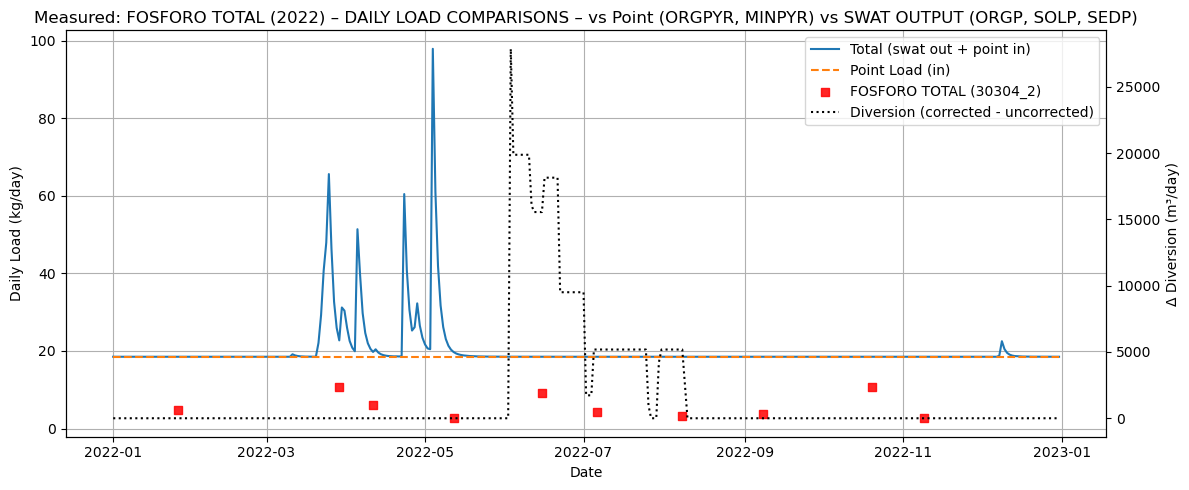

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Optional toggle
plot_diversion_series = True
diversion_log_scale = False
save_plots = True   # 🔁 Set to True to save as PNGs
show_plots = True    # 🔁 Set to True to view inline
out_dir_base = "plots_read_sub/comparing_dma_swat_point_diversion"  # 🔁 Base output folder

# Prepare dates and years
df_cubillas_chem_measur_clean["date"] = pd.to_datetime(df_cubillas_chem_measur_clean["F_MUESTREO"])
df_cubillas_chem_measur_clean["YEAR"] = df_cubillas_chem_measur_clean["date"].dt.year
plot_dayli_cubillas["date"] = pd.to_datetime(plot_dayli_cubillas["date"])
plot_dayli_cubillas["YEAR"] = plot_dayli_cubillas["date"].dt.year

if plot_diversion_series:
    diversion_series_2["Fecha (día)"] = pd.to_datetime(diversion_series_2["Fecha (día)"])

# Clean kg_por_dia
df_cubillas_chem_measur_clean["kg_por_dia"] = (
    df_cubillas_chem_measur_clean["kg_por_dia"]
    .astype(str).str.replace(",", ".", regex=False)
    .astype(float)
)

# Selected COD_UEs
selected_cod_ue = ["30304_2", "30304"]

# Set up color and marker maps
unique_nombres = df_cubillas_chem_measur_clean["NOMBRE"].unique()
color_map_nombres = {name: f"C{i % 10}" for i, name in enumerate(sorted(unique_nombres))}
marker_shapes = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X']
cod_ue_marker_map = {cod: marker_shapes[i % len(marker_shapes)] for i, cod in enumerate(sorted(selected_cod_ue))}

# Year range
years = range(2000, 2023)

# Iterate over DMA variables
for dma_var, info in column_mapping_dma_based.items():
    swat_cols = info["swat"]
    point_cols = info["point"]

    out_dir = os.path.join(out_dir_base, dma_var.replace(" ", "_"))
    os.makedirs(out_dir, exist_ok=True)

    for year in years:
        # Filter DMA data
        dma_data_year = df_cubillas_chem_measur_clean[
            (df_cubillas_chem_measur_clean["YEAR"] == year) &
            (df_cubillas_chem_measur_clean["NOMBRE"] == dma_var) &
            (df_cubillas_chem_measur_clean["COD_UE"].isin(selected_cod_ue))
        ]
        if dma_data_year.empty:
            continue

        # Diffuse data for the year
        daily_diffuse = plot_dayli_cubillas[plot_dayli_cubillas["YEAR"] == year].copy()
        if daily_diffuse.empty:
            continue

        # Point source data for the year
        point_row = df_cubillas_point[df_cubillas_point["YEAR"] == year]
        if point_row.empty:
            print(f"⚠️ No point source data for {dma_var} in {year}. Skipping.")
            continue

        # Compute summed point value
        point_val = sum([point_row[col].values[0] for col in point_cols if col in point_row])
        print(f"[{year}] Point source daily mean for '{dma_var}': {point_val:.2f}")

        # Sum SWAT columns
        daily_diffuse["swat_sum"] = daily_diffuse[swat_cols].sum(axis=1)
        daily_diffuse["point_val"] = point_val
        daily_diffuse["total_load"] = daily_diffuse["swat_sum"] + point_val

        # === Plot Setup ===
        fig, ax = plt.subplots(figsize=(12, 5))
        legend_handles = []
        legend_labels = []

        # Total + Point lines
        h_total, = ax.plot(daily_diffuse["date"], daily_diffuse["total_load"], label="Total (Diffuse + Point)", color="tab:blue")
        h_point, = ax.plot(daily_diffuse["date"], daily_diffuse["point_val"], label="Point Load (Flat)", linestyle="--", color="tab:orange")
        legend_handles += [h_total, h_point]
        legend_labels += ["Total (swat out + point in)", "Point Load (in)"]


        # DMA scatter points - always red
        for cod_ue, group in dma_data_year.groupby("COD_UE"):
            marker = cod_ue_marker_map.get(cod_ue, 'o')
            label = f"{dma_var} ({cod_ue})"
            h_dma = ax.scatter(group["date"], group["kg_por_dia"], label=label, alpha=0.85, color="red", marker=marker)
            legend_handles.append(h_dma)
            legend_labels.append(label)

        # Diversion series (secondary axis)
        ax2 = None
        if plot_diversion_series:
            diversion_year = diversion_series_2[
                (diversion_series_2["Fecha (día)"].dt.year == year) &
                (diversion_series_2["uncorrected - corrected"].notna())
            ]
            if not diversion_year.empty:
                ax2 = ax.twinx()
                diversion_values = diversion_year["uncorrected - corrected"].clip(lower=1e-2)

                if diversion_log_scale:
                    ax2.set_yscale("log")
                    ax2.set_ylim(diversion_values.min(), diversion_values.max())
                else:
                    ax2.set_yscale("linear")

                h_diversion, = ax2.plot(
                    diversion_year["Fecha (día)"],
                    diversion_values,
                    color="black", linestyle="dotted",
                    label="Corrected - Uncorrected (Diversion)"
                )
                ax2.set_ylabel("Δ Diversion (m³/day)", color="black")
                ax2.tick_params(axis='y', labelcolor='black')
                legend_handles.append(h_diversion)
                legend_labels.append("Diversion (corrected - uncorrected)")

        # Final plot formatting
        swat_str = ", ".join(swat_cols)
        point_str = ", ".join(point_cols)
        plt.title(f"Measured: {dma_var} ({year}) – DAILY LOAD COMPARISONS – vs Point ({point_str}) vs SWAT OUTPUT ({swat_str})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Daily Load (kg/day)")
        ax.grid(True)
        ax.legend(legend_handles, legend_labels, loc="best")
        plt.tight_layout()

        # Save or Show
        if save_plots:
            out_path = os.path.join(out_dir, f"{dma_var.replace(' ', '_')}_{year}.png")
            plt.savefig(out_path, dpi=300)
            print(f"✅ Saved: {out_path}")
        if show_plots:
            plt.show()

        plt.close()


## 

## aggregate by date and basin

see https://pandas.pydata.org/pandas-docs/version/1.3.1/getting_started/intro_tutorials/09_timeseries.html

In [ ]:
# Group by both 'basin' and 'year', then compute the mean of all other columns
df_sub_scaled_yearly = df_sub_scaled.groupby(["SUB", "YEAR"], as_index=False).mean(numeric_only=True)

df_sub_scaled_yearly[df_sub_scaled_yearly["YEAR"] == 2013]


#df_sub_scaled_yearly[df_sub_scaled_yearly["SUB"] == 1]

SUB  YEAR  total_days  GIS    MON   area_ha        AREA       PRECIP  \
22     1  2013      8218.0  0.0  183.0   941.120   9411200.0  1822.678707   
56     2  2013      8218.0  0.0  183.0   276.940   2769400.0   635.672142   
90     3  2013      8218.0  0.0  183.0   542.830   5428300.0   839.081332   
124    4  2013      8218.0  0.0  183.0   295.540   2955400.0   463.471496   
158    5  2013      8218.0  0.0  183.0   213.120   2131200.0   309.870641   
192    6  2013      8218.0  0.0  183.0   458.340   4583400.0   991.521271   
226    7  2013      8218.0  0.0  183.0   162.620   1626200.0   330.764625   
260    8  2013      8218.0  0.0  183.0   301.340   3013400.0   485.281238   
294    9  2013      8218.0  0.0  183.0   675.940   6759400.0  1167.987282   
328   10  2013      8218.0  0.0  183.0   509.920   5099200.0  1205.227353   
362   11  2013      8218.0  0.0  183.0  1068.100  10681000.0  2015.929014   
396   12  2013      8218.0  0.0  183.0   179.990   1799900.0   335.323836   
430   13  2013      8218.0  0.0  183.0   113.860   1138600.0   168.918329   
464   14  2013      8218.0  0.0  183.0   197.490   1974900.0   295.369290   
498   15  2013      8218.0  0.0  183.0   166.650   1666500.0   240.295603   
532   16  2013      8218.0  0.0  183.0   234.270   2342700.0   361.866921   
566   17  2013      8218.0  0.0  183.0    45.219    452190.0    65.536578   

      SNOMELT       PET  ...  GW_Q      WYLD      SYLD       ORGN      ORGP  \
22    0.00000  4.181323  ...   0.0  0.736767  0.000869  11.316198  1.536599   
56    0.00000  4.074452  ...   0.0  0.727896  0.000807   1.754583  0.215600   
90    0.00000  4.124225  ...   0.0  0.287224  0.000138   0.919096  0.124347   
124   0.00000  4.188501  ...   0.0  0.332507  0.000104   0.441088  0.060856   
158   0.00000  4.361534  ...   0.0  0.267521  0.000266   0.699192  0.093777   
192   0.00000  4.135767  ...   0.0  0.691616  0.000739   3.044718  0.377869   
226   0.00000  3.885175  ...   0.0  0.577003  0.000899   0.636505  0.077510   
260   0.00000  3.699560  ...   0.0  0.407570  0.001153   2.435625  0.312185   
294   0.00000  3.804066  ...   0.0  0.383601  0.002478   9.387640  1.176383   
328   0.00000  3.805781  ...   0.0  0.855773  0.012962  12.799833  1.591795   
362   0.00000  3.734519  ...   0.0  0.613345  0.005889  10.990486  1.343763   
396  10.19779  3.504310  ...   0.0  0.463989  0.038841   3.997894  0.497210   
430   0.00000  3.811084  ...   0.0  0.462106  0.000071   0.075522  0.007924   
464   0.00000  3.740605  ...   0.0  0.481086  0.000117   0.212161  0.022675   
498   0.00000  4.012104  ...   0.0  0.472493  0.000061   0.114476  0.013635   
532   0.00000  3.735030  ...   0.0  0.307810  0.011504   2.446050  0.301210   
566   0.00000  3.843482  ...   0.0  0.372900  0.000085   0.046484  0.005825   

        NSURQ      SOLP      SEDP  P_inorg_total  day_of_year  
22   0.334268  0.000134  0.001461       0.001595        183.0  
56   0.010966  0.000022  0.000996       0.001018        183.0  
90   0.011772  0.000012  0.000257       0.000269        183.0  
124  0.015157  0.000023  0.000208       0.000231        183.0  
158  0.013621  0.000024  0.000434       0.000458        183.0  
192  0.041099  0.000072  0.000882       0.000953        183.0  
226  0.006953  0.000038  0.000740       0.000778        183.0  
260  0.031981  0.000043  0.001227       0.001270        183.0  
294  0.041850  0.000043  0.002224       0.002267        183.0  
328  0.026508  0.000100  0.004119       0.004219        183.0  
362  0.038363  0.000051  0.001670       0.001721        183.0  
396  0.000321  0.000008  0.003761       0.003769        183.0  
430  0.014762  0.000063  0.000090       0.000153        183.0  
464  0.013150  0.000059  0.000147       0.000206        183.0  
498  0.030106  0.000054  0.000086       0.000140        183.0  
532  0.003869  0.000016  0.001763       0.001780        183.0  
566  0.002194  0.000027  0.000127       0.000154        183.0  

[17 rows x 24 columns]

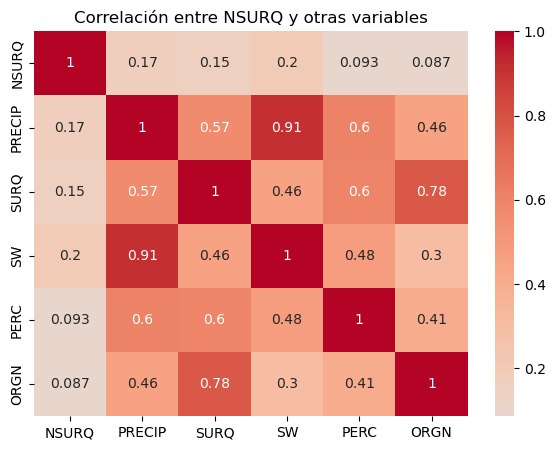

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

vars_to_correlate = ["NSURQ", "PRECIP", "SURQ", "SW", "PERC", "ORGN"]
corr_matrix = df_sub_scaled_yearly[vars_to_correlate].corr()
# corr_matrix = df_sub_scaled.groupby("SUB")[["NSURQ", "SW", "PRECIP"]].corr().unstack()
# corr_matrix = peaks[(peaks["SUB"] == 1) & (peaks["YEAR"] == 2013)][vars_to_correlate].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlación entre NSURQ y otras variables")
plt.show()

### SUM all subbasins

In [ ]:



df_cubillas_yearly_diffuse = df_sub_scaled_yearly.groupby(["YEAR"], as_index=False)[["ORGN", "ORGP", "NSURQ", "P_inorg_total", "PRECIP", "SW", "PERC", "SURQ"]].sum(numeric_only=True)

df_cubillas_yearly_diffuse.head(34)

YEAR        ORGN       ORGP     NSURQ  P_inorg_total        PRECIP  \
0   1991    0.031726   0.003888  0.000008   2.615865e-05   5874.814856   
1   1992    0.024313   0.003363  0.000647   1.273747e-05   6932.511267   
2   1993    0.001704   0.000308  0.000159   4.465335e-07   4476.130795   
3   1994    0.022710   0.003870  0.000367   4.499041e-06   4828.995149   
4   1995    0.000002   0.000002  0.000002   1.329400e-08   4669.255128   
5   1996    6.142791   0.817626  0.200720   3.034171e-03  12310.068688   
6   1997    7.101210   0.917022  0.302943   3.136115e-03  10803.039795   
7   1998    1.116684   0.143454  0.005214   5.799119e-04   5186.136298   
8   1999    0.186247   0.026325  0.000264   3.553557e-05   5716.008106   
9   2000    4.208398   0.546624  0.084347   3.183378e-03   8976.705793   
10  2001   25.135655   3.263105  0.135975   1.137846e-02   9598.180618   
11  2002    6.644851   0.903183  0.139427   1.675609e-03   9586.491897   
12  2003   14.254574   1.798770  0.234262   6.664038e-03  10134.015044   
13  2004   23.704968   3.076730  0.240838   1.001826e-02   8471.204674   
14  2005    0.004823   0.000619  0.004160   1.555653e-06   4347.718448   
15  2006    0.394888   0.055732  0.005344   7.033674e-05   7573.394044   
16  2007    0.961911   0.120650  0.021227   2.242722e-04   6133.872070   
17  2008    5.211362   0.751212  0.597326   9.054416e-04  10245.433994   
18  2009   21.340547   2.662004  0.108617   1.097583e-02  11199.777619   
19  2010   33.100113   4.200660  0.332681   1.403347e-02  14980.408714   
20  2011   10.113461   1.288965  3.867591   3.903202e-03   8465.403250   
21  2012    0.779596   0.106350  0.082110   1.322106e-04   8820.803963   
22  2013   61.317552   7.759164  0.636939   2.098251e-02  11734.795658   
23  2014    4.311517   0.561294  0.097973   1.768164e-03   7898.158691   
24  2015    2.547630   0.354989  0.114546   6.912457e-04   5251.133545   
25  2016   18.815624   2.348972  0.098434   1.250925e-02   9564.200747   
26  2017   13.131573   1.743541  0.047891   6.543564e-03   6595.483915   
27  2018  160.509104  20.426227  0.706991   6.786453e-02  14396.817385   
28  2019    8.214928   1.083765  0.297357   3.921219e-03   9407.712340   
29  2020    2.025688   0.256548  0.036888   1.194221e-03   7436.034359   
30  2021    3.467458   0.431659  0.041442   2.867278e-03   7320.723810   
31  2022   12.953471   1.647880  0.072966   9.456310e-03   8208.044173   
32  2023    1.052384   0.132727  0.023550   6.698878e-04   5698.524130   
33  2024   92.983150  12.120588  0.704973   3.820201e-02  18373.746016   

              SW         PERC         SURQ  
0   5.941179e+05     0.000000     0.043368  
1   9.991519e+05     0.000000     1.002572  
2   9.201081e+05     0.000000     0.081404  
3   8.392861e+05     0.000000     1.201275  
4   4.816347e+05     0.000000     0.001733  
5   1.344013e+06   709.433155    43.267671  
6   1.453968e+06  1368.522590   190.106290  
7   1.287887e+06   155.279658    13.570340  
8   7.715805e+05     0.000000     2.742610  
9   1.036308e+06   401.435415    18.193879  
10  1.425958e+06  1109.737371   366.108965  
11  1.326800e+06   177.908724   123.953051  
12  1.456522e+06   676.927099   243.421395  
13  1.445713e+06   168.145895   407.822676  
14  8.187128e+05     0.000000     0.046729  
15  1.066813e+06     2.597573     6.243087  
16  9.645495e+05     1.211020     4.477769  
17  1.301948e+06   222.604073    51.071008  
18  1.305548e+06  1731.519579   241.012991  
19  1.451434e+06  3935.783392   380.827392  
20  1.476161e+06   452.588782   221.951716  
21  1.112476e+06   328.317215    13.179763  
22  1.474170e+06  2045.148467  1087.586806  
23  1.221860e+06   506.162921    78.761284  
24  1.041690e+06    26.554067    26.339605  
25  1.055147e+06   214.430051    70.143224  
26  1.111288e+06    13.859376   110.203092  
27  1.475908e+06  2146.081675  1295.288488  
28  1.296808e+06   347.328211    94.738738  
29  1.320535e+06   110.377018    22.251658  
30  1.183387e+06  

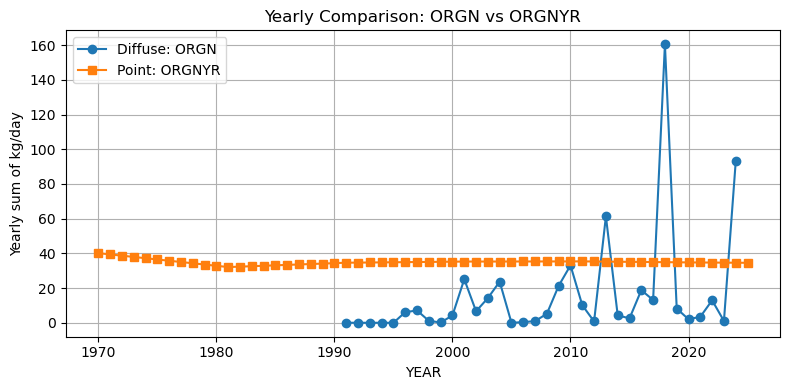

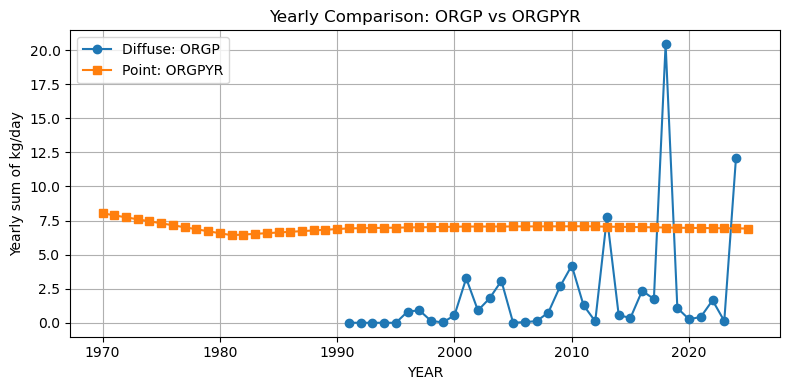

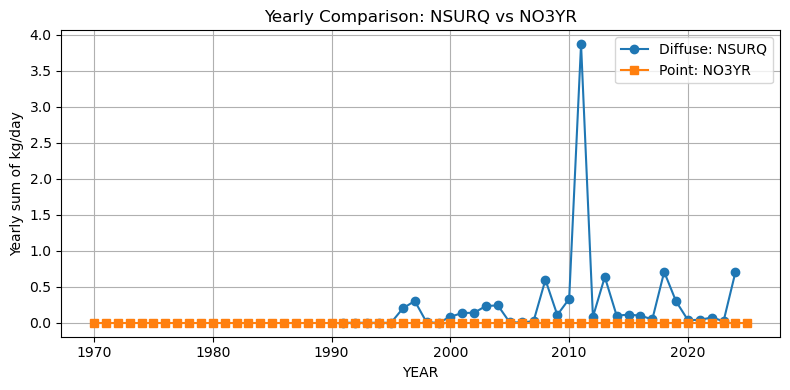

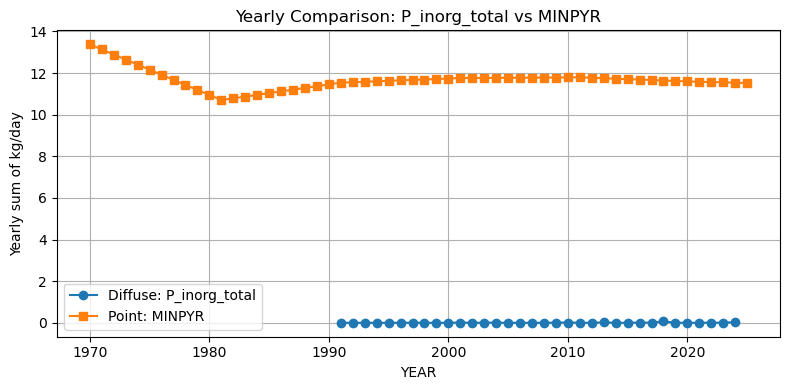

In [ ]:
import matplotlib.pyplot as plt

# Ensure 'YEAR' columns are numeric
df_cubillas_yearly_diffuse["YEAR"] = pd.to_numeric(df_cubillas_yearly_diffuse["YEAR"])
df_cubillas_point["YEAR"] = pd.to_numeric(df_cubillas_point["YEAR"])

# Loop through the mapping dictionary
for col_a, col_b in column_mapping.items():
    # Check if both columns exist
    if col_a not in df_cubillas_yearly_diffuse.columns:
        print(f"Column '{col_a}' not found in diffuse dataset.")
        continue
    if col_b not in df_cubillas_point.columns:
        print(f"Column '{col_b}' not found in point dataset.")
        continue

    # Merge on YEAR
    merged = df_cubillas_yearly_diffuse[["YEAR", col_a]].merge(
        df_cubillas_point[["YEAR", col_b]],
        on="YEAR",
        how="outer",
        suffixes=("_a", "_b")
    ).sort_values("YEAR")

    #merged[col_b] = merged[col_b] *365

    # Plot both series
    plt.figure(figsize=(8, 4))
    plt.plot(merged["YEAR"], merged[f"{col_a}"], marker='o', label=f"Diffuse: {col_a}")
    plt.plot(merged["YEAR"], merged[f"{col_b}"], marker='s', label=f"Point: {col_b}")
    plt.title(f"Yearly Comparison: {col_a} vs {col_b}")
    plt.xlabel("YEAR")
    plt.ylabel("Yearly sum of kg/day")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


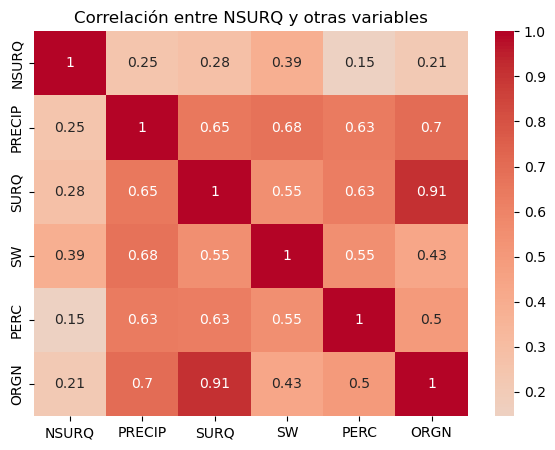

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

vars_to_correlate = ["NSURQ", "PRECIP", "SURQ", "SW", "PERC", "ORGN"]
corr_matrix = df_cubillas_yearly_diffuse[vars_to_correlate].corr()
# corr_matrix = df_cubillas_yearly_diffuse.groupby("YEAR")[["NSURQ", "SW", "PRECIP"]].corr().unstack()

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlación entre NSURQ y otras variables")
plt.show()

In [ ]:
subset = df_sub_scaled[(df_sub_scaled["YEAR"] == 2014) & (df_sub_scaled["SUB"] == 6)]

# Check if all rows are identical
all_identical = subset.drop(columns=["SUB", "YEAR", "date"]).nunique().eq(1).all()
print("All rows identical:", all_identical)

subset


All rows identical: False


total_days  SUB  GIS       date  YEAR  MON  area_ha       AREA  \
142822        8401    6    0 2014-01-01  2014    1   458.34  4583400.0   
142839        8402    6    0 2014-01-02  2014    2   458.34  4583400.0   
142856        8403    6    0 2014-01-03  2014    3   458.34  4583400.0   
142873        8404    6    0 2014-01-04  2014    4   458.34  4583400.0   
142890        8405    6    0 2014-01-05  2014    5   458.34  4583400.0   
...            ...  ...  ...        ...   ...  ...      ...        ...   
148942        8761    6    0 2014-12-27  2014  361   458.34  4583400.0   
148959        8762    6    0 2014-12-28  2014  362   458.34  4583400.0   
148976        8763    6    0 2014-12-29  2014  363   458.34  4583400.0   
148993        8764    6    0 2014-12-30  2014  364   458.34  4583400.0   
149010        8765    6    0 2014-12-31  2014  365   458.34  4583400.0   

          PRECIP  SNOMELT  ...  GW_Q    WYLD          SYLD      ORGN  \
142822   229.170      0.0  ...   0.0  0.4360  2.940000e-05  1.173350   
142839   962.514      0.0  ...   0.0  0.3930  1.830000e-05  0.907513   
142856   595.842      0.0  ...   0.0  0.3590  1.140000e-05  0.710427   
142873  3666.720      0.0  ...   0.0  0.3540  7.190000e-06  0.559175   
142890     0.000      0.0  ...   0.0  0.3260  4.540000e-06  0.443215   
...          ...      ...  ...   ...     ...           ...       ...   
148942     0.000      0.0  ...   0.0  0.0518  7.710000e-13  0.000004   
148959   550.008      0.0  ...   0.0  0.0505  7.200000e-13  0.000004   
148976     0.000      0.0  ...   0.0  0.0493  6.820000e-13  0.000003   
148993     0.000      0.0  ...   0.0  0.0481  6.550000e-13  0.000003   
149010     0.000      0.0  ...   0.0  0.0471  6.340000e-13  0.000002   

                ORGP         NSURQ          SOLP          SEDP  P_inorg_total  \
142822  1.663774e-01  8.754294e-08  4.770000e-05  1.720000e-04   2.197000e-04   
142839  1.287935e-01  8.754294e-08  3.710000e-05  1.330000e-04   1.701000e-04   
142856  1.008348e-01  8.754294e-08  2.920000e-05  1.030000e-04   1.322000e-04   
142873  7.929282e-02  8.754294e-08  2.310000e-05  8.130000e-05   1.044000e-04   
142890  6.325092e-02  8.754294e-08  1.830000e-05  6.430000e-05   8.260000e-05   
...              ...           ...           ...           ...            ...   
148942  6.875100e-07  9.441804e-08  3.880000e-10  9.320000e-10   1.320000e-09   
148959  5.866752e-07  9.350136e-08  3.590000e-10  8.390000e-10   1.198000e-09   
148976  5.041740e-07  9.258468e-08  3.350000e-10  7.620000e-10   1.097000e-09   
148993  4.377147e-07  9.166800e-08  3.140000e-10  6.980000e-10   1.012000e-09   
149010  3.813389e-07  9.120966e-08  2.960000e-10  6.450000e-10   9.410000e-10   

        day_of_year  
142822            1  
142839            2  
142856            3  
142873            4  
142890            5  
...             ...  
148942          361  
148959          362  
148976          363  
148993          364  
149010          365  

[365 rows x 25 columns]

In [ ]:
value = 2.560000e-07
formatted = f"{value:.10f}"  # 10 decimal places
print(formatted)

0.0000002560
